In [1]:
%matplotlib inline
#import fleks,yt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import stats
import numpy as np
import os
import re
#from utilities import get_ticks
from matplotlib import cm, ticker
from os import listdir
from os.path import isfile, join
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import LogLocator, LogFormatterSciNotation 
import tecplot as tp
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from tecplot.exception import *
from tecplot.constant import *
import pandas as pd
from scipy.interpolate import griddata
from operator import add
from scipy.ndimage import label
import pickle
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
%matplotlib inline
#import fleks,yt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import stats
import numpy as np
import os
import re
#from utilities import get_ticks
from matplotlib import cm, ticker
from os import listdir
from os.path import isfile, join
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import LogLocator, LogFormatterSciNotation 
import tecplot as tp
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from tecplot.exception import *
from tecplot.constant import *
import pandas as pd
from scipy.interpolate import griddata
from operator import add
from scipy.ndimage import label
import pickle
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [3]:
# Define Constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg
e = 1.60218e-19 # C

# Define utility functions
def read_dataset(mypath):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect()

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset

def Bz_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: Bz at each point
    
    return - 200.9 * (3*(z_array-0.2)**2 - (x_array**2+y_array**2+(z_array-0.2)**2))/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

def extract_line(plane,line_start,line_end,num_points=200):
    # Input: 2d slice of domain (cannot be xz plane) format as a dictionary (like output from extract_values_fast), 
    # and the endpoints of a line to extract data for
    # Output: dictionary with same keys as the plane, but for data along the line
    
    # Define arrays for the line
    x_axis = np.linspace(line_start[0],line_end[0],num_points)
    y_axis = np.linspace(line_start[1],line_end[1],num_points)
    
    # Define empty arrays for each value stored in the plane dictionary
    out_dict = {}
    for key in plane.keys():
        out_dict[key]=np.zeros_like(x_axis)

    # Interpolate to points
    for key in plane.keys():
        out_dict[key] = griddata( (plane["X"].ravel(),plane["Y"].ravel()), plane[key].ravel(), (x_axis,y_axis))
    
    return out_dict

def get_files(dir, key=".*cut_particle_region0_0.*", read_time = False, reduce = True):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    
    # Now give them the appropriate name for their time
    # If we haven't already named these files with their time, do that now
    named_files = {}
    if read_time == False:
        for i in range(len(files)):
            time = round(i*dt+start_time,3)
            named_files[time] = files[i]
    # Otherwise, read the time right from the (last 6 elements) filename
    else:
        for i in range(len(files)):
            time = str("%.2f"%float(files[i][-6:]))
            named_files[time] = files[i]        
    
    # Now cut the list down to files inside t_bound
    if reduce:
        reduced_files = {}
        for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
            reduced_files[time] = str(named_files[time])
        return reduced_files

    else:
        return named_files

def convert_to_plt(dir,files):
    # Hand it a directory with the dict of files in it, and it will convert them to .plt and save in dir
    
    for file in files:
        dataset=read_dataset(str(dir+files[file]))
        print("saving file:",str(dir+files[file][:-3]+"plt"))
        tp.data.save_tecplot_plt(str(dir+files[file][:-3]+"plt"))

def extract_current_surface(path,var_ls=["Bz"]):
    # Input: the path to a .plt file, and a list of variables to extract for each point in current sheet
    # Output: a dictionary of arrays, each labelled according to its name in var_ls
    # Var_ls should be *extensive*, so that this long process does not need to be rerun
    
    # First, read in the dataset with tecplot
    dataset = read_dataset(path)

    # Extract the coordinate axes
    x_axis = np.unique(dataset.variable("X").values(0).as_numpy_array())
    y_axis = np.unique(dataset.variable("Y").values(0).as_numpy_array())[1:-1]
    z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())

    # Create an ordered zone
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis-2),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X')[:] = xxx.ravel()
    rect_zone.values('Y')[:] = yyy.ravel()
    rect_zone.values('Z')[:] = zzz.ravel()

    # Compute derivatives in tecplot, which does it efficiently
    # Compute current density, in A/m^2
    if ("Jx" in var_ls) or ("Jy" in var_ls) or ("Jz" in var_ls):
        print("Computing J = ∇xB")
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)

    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = (ddx({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)

    # Calculate the plasma beta meshgrid
    beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+
                            rect_zone.values("pyyS1").as_numpy_array()+rect_zone.values("pzzS1").as_numpy_array())*1e9/3/(rect_zone.values("Bx").as_numpy_array()**2+rect_zone.values("By").as_numpy_array()**2+rect_zone.values("Bz").as_numpy_array()**2)).reshape(xxx.shape)
    beta_meshgrid[np.isnan(beta_meshgrid)] = -1

    # Define dictionary to save results
    data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}

    print("Interpolation complete, searching for max beta and saving data")
    
    # Interate through each x,y coord to find the max beta on that z-line and save the data
    for name in np.concatenate([["Z"],var_ls]):
        print("Extracting",name)
        data[name] = np.zeros_like(xxx[:,:,0])

        # Extract each variable from tecplot as an array
        var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)

        # At each x/y, find the z coord of max beta and save that
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                # In this case, set the data value to 0 to let me know where the boundary is!
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    data[name][idy,idx] = 0
                else:
                    idz = np.argmax(beta_meshgrid[idy,idx,:])
                    data[name][idy,idx] = var[idy,idx,idz]


    print("Complete!")
    return data

def average_value(var_ls,t0,t_start,t_stop):
    # Input: Variables to average, the current time (t0), and the times relative to present to average over (t0+t_start to t0+t_stop)
    # Ouput: dictionary of arrays of time-averaged values

    averages = {}
    count = 0

    temp_files = get_files(dir,key="3d\_fluid.*\_t\_...\...",read_time = True, reduce = False)
    for t in list(temp_files.keys()): 
        # Check to see if this file is in the time range we want
        if (float(t) >= (t0+t_start)) and (float(t) <= t0+t_stop):
            temp_file = str(temp_files[t])
    
            # Read in this data
            with open(dir+temp_file, 'rb') as f:
                temp_data = pickle.load(f) 
            
            # Add the data to our running average for each variable
            for var in var_ls:
                if var not in averages.keys():
                    averages[var] = temp_data[var]
                else:
                    averages[var] += temp_data[var]

            count += 1
        
    # Divide by total time steps
    for var in var_ls:
        averages[var] = averages[var]/count

    return averages

def compute_dt(var_ls,time):
    # Input: variables to compute the time derivative for, and the current time
    # Output: dictionary of time derivatives for each variable, calculated as dvar_dt = var(time+dt)-var(time-dt)/(2*dt)
    # If earlier or later times are not available, we do either var(time+dt)-var(time)/dt or var(time)-var(time-dt)/dt

    # Declare output dictionary
    deriv_dict = {}
    print("Computing time derivatives at time",time)
    key_minus = '{:.2f}'.format((float(time)-dt), 'wb')
    key_plus = '{:.2f}'.format((float(time)+dt), 'wb')
    #print(files.keys())
    #print(key_minus)
    #print(key_plus)

    # Read in the data depending on whether its available
    if (key_minus in files.keys()) and (key_plus in files.keys()):
        # Case one: earlier and later timestep available, so use both
        print("Earlier and later timesteps available!")
        with open(dir+files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        with open(dir+files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data_tminus[var])/(2*dt)
    
    elif (key_minus in files.keys()):
        # Case two: only earlier time available
        print("Only earlier timestep available!")
        with open(dir+files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data[var]-data_tminus[var])/(dt)

    elif (key_plus in files.keys()):
        # Case three: only later time available
        print("Only later timestep available!")
        print(dir+files[key_plus])
        with open(dir+files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data[var])/(dt)

    else:
        print("ERROR: NO OTHER TIMESTEPS FOUND FOR DERIVATIVE")
            
    return deriv_dict
    

In [ ]:
# STEP ONE: process data
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/ta-5/" #   # Directory with data 
start_time = 70                                              # What is the start time of the dataset?
t_bound = [70,107] #70,107                                                   # Start and stop times of this data to be processed
dt = 0.05                                                     # What is the timestep between files?
convert_first = True # Set to true to make sure files are converted from .dat to .plt. Set to false if there are .dat files in the directory which do not need to be converted

var_ls = ["Bx","By","Bz","Ex","Ey","Ez","rhoS0","uxS0","uyS0","uzS0","pxxS0","pyyS0","pzzS0","pxyS0","pxzS0","pyzS0",
          "rhoS1","uxS1","uyS1","uzS1","pxxS1","pyyS1","pzzS1","pxyS1","pxzS1","pyzS1","Jx","Jy","Jz","dp_dx","dp_dy","dp_dz",
          "dB_dx","dB_dy","dB_dz"]


# RUN
if convert_first:
    files = get_files(dir,key="3d\_fluid.*\.dat")
    convert_to_plt(dir,files)

files = get_files(dir,key="3d\_fluid.*\.plt")

for time in list(files.keys()): 
    print("Extracting data for t =",time)
    file = str(files[time])
    data = extract_current_surface(dir+file,var_ls=var_ls)

    print("Extraction complete! Saving...")
    
    save_file = open(str(dir+file[:-4]+"_csdata_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
    pickle.dump(data, save_file) 
    

reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/ta-5/3d_fluid_region0_0_t00000120_n00017863_amrex.dat
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
saving file: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/ta-5/3d_fluid_region0_0_t00000120_n00017863_amrex.plt
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/ta-5/3d_fluid_region0_0_t00000120_n00017883_amrex.dat
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
saving file: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/ta-5/3d_fluid_region0_0_t00000120_n00017883_amrex.plt
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/ta-5/3d_fluid_region0_0_t00000120_n00017902_amrex.dat
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
saving file: /Users/atcushen/Documents/MercuryModelling/runs/nigh

Plotting t = 48.00
Computing time derivatives at time 48.00
Only later timestep available!
/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/all_ta/3d_fluid_region0_0_t00000048_n00005633_amrex_csdata_t_048.05
Found 1 DFs at this time


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.05
Computing time derivatives at time 48.05
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 322]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.10
Computing time derivatives at time 48.10
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 341]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.15
Computing time derivatives at time 48.15
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 359]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.20
Computing time derivatives at time 48.20
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 360]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.25
Computing time derivatives at time 48.25
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 369]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#2
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.30
Computing time derivatives at time 48.30
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 375]
 [  3   2  18]
 [  1   1  13]]
DF#1 has been tracked from the previous step
DF#2 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#3
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.35
Computing time derivatives at time 48.35
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 392]
 [  2   2  35]]
DF#1 has been tracked from the previous step
DF#2 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.40
Computing time derivatives at time 48.40
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 315]
 [  2   1  65]
 [  3   2  42]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#2 has been tracked from the previous step
Reassigning the temporary DF#-1 to DF#4
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.45
Computing time derivatives at time 48.45
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#4
New DF#2 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 332]
 [  2   2  52]]
DF#1 has been tracked from the previous step
DF#2 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.50
Computing time derivatives at time 48.50
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 418]
 [  2   2  58]]
DF#1 has been tracked from the previous step
DF#2 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.55
Computing time derivatives at time 48.55
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 428]
 [  2   2  62]]
DF#1 has been tracked from the previous step
DF#2 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.60
Computing time derivatives at time 48.60
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 464]
 [  2   2  64]]
DF#1 has been tracked from the previous step
DF#2 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.65
Computing time derivatives at time 48.65
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 500]
 [  2   2  73]]
DF#1 has been tracked from the previous step
DF#2 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.70
Computing time derivatives at time 48.70
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 510]
 [  2   2  75]]
DF#1 has been tracked from the previous step
DF#2 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.75
Computing time derivatives at time 48.75
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#2
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 530]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.80
Computing time derivatives at time 48.80
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 629]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.85
Computing time derivatives at time 48.85
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 639]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.90
Computing time derivatives at time 48.90
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 634]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 48.95
Computing time derivatives at time 48.95
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 646]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.00
Computing time derivatives at time 49.00
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 658]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.05
Computing time derivatives at time 49.05
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 664]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.10
Computing time derivatives at time 49.10
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 662]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#5
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.15
Computing time derivatives at time 49.15
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#5
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 676]
 [  2   5  12]]
DF#1 has been tracked from the previous step
DF#5 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.20
Computing time derivatives at time 49.20
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#5
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 675]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.25
Computing time derivatives at time 49.25
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 722]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.30
Computing time derivatives at time 49.30
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 726]
 [  1   1  13]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#6
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.35
Computing time derivatives at time 49.35
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#6
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 778]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.40
Computing time derivatives at time 49.40
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 791]
 [  1   1  16]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#7
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.45
Computing time derivatives at time 49.45
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#7
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 812]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.50
Computing time derivatives at time 49.50
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 840]
 [  1   1  20]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#8
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.55
Computing time derivatives at time 49.55
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 830]
 [  1   8  19]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.60
Computing time derivatives at time 49.60
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 830]
 [  1   8  28]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.65
Computing time derivatives at time 49.65
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 852]
 [  1   8  25]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.70
Computing time derivatives at time 49.70
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 865]
 [  1   8  27]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.75
Computing time derivatives at time 49.75
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 874]
 [  1   8  24]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.80
Computing time derivatives at time 49.80
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#8
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 895]
 [  1   8  14]
 [  2   8  10]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
DF#8 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#9
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.85
Computing time derivatives at time 49.85
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#1 overlaps with old DF#9
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 906]
 [  1   8  18]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.90
Computing time derivatives at time 49.90
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 898]
 [  1   8  20]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 49.95
Computing time derivatives at time 49.95
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 856]
 [  2   1  28]
 [  1   8  22]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#8 has been tracked from the previous step
Reassigning the temporary DF#-1 to DF#10
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.00
Computing time derivatives at time 50.00
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#1
New DF#3 overlaps with old DF#10
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 874]
 [  1   8  21]
 [  2   1  20]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#11
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.05
Computing time derivatives at time 50.05
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
New DF#2 overlaps with old DF#11
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 844]
 [  2   1  34]
 [  1   8  23]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#8 has been tracked from the previous step
Reassigning the temporary DF#-1 to DF#12
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.10
Computing time derivatives at time 50.10
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
New DF#2 overlaps with old DF#12
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 849]
 [  2  12  27]
 [  1   8  20]]
DF#1 has been tracked from the previous step
DF#12 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.15
Computing time derivatives at time 50.15
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#12
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 853]
 [  2  12  20]
 [  1   8  18]]
DF#1 has been tracked from the previous step
DF#12 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.20
Computing time derivatives at time 50.20
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#12
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 858]
 [  1   8  20]
 [  2  12  18]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
DF#12 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.25
Computing time derivatives at time 50.25
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#12
New DF#3 overlaps with old DF#1
New DF#3 overlaps with old DF#12
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 873]
 [  1   8  21]
 [  2  12  12]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
DF#12 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.30
Computing time derivatives at time 50.30
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 882]
 [  1   8  19]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.35
Computing time derivatives at time 50.35
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 873]
 [  1   8  13]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.40
Computing time derivatives at time 50.40
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#8
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 889]
 [  1   8  12]]
DF#1 has been tracked from the previous step
DF#8 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.45
Computing time derivatives at time 50.45
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 885]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.50
Computing time derivatives at time 50.50
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 884]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.55
Computing time derivatives at time 50.55
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 914]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.60
Computing time derivatives at time 50.60
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 924]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.65
Computing time derivatives at time 50.65
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 936]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.70
Computing time derivatives at time 50.70
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 941]
 [  1  -1   0]]
DF#1 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#13
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.75
Computing time derivatives at time 50.75
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 961]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.80
Computing time derivatives at time 50.80
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 971]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.85
Computing time derivatives at time 50.85
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 982]
 [  1  -1   0]]
DF#1 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#14
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.90
Computing time derivatives at time 50.90
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1001]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 50.95
Computing time derivatives at time 50.95
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1013]
 [   1   -1    0]]
DF#1 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#15
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.00
Computing time derivatives at time 51.00
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1039]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.05
Computing time derivatives at time 51.05
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1045]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.10
Computing time derivatives at time 51.10
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1063]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.15
Computing time derivatives at time 51.15
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1048]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.20
Computing time derivatives at time 51.20
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1052]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.25
Computing time derivatives at time 51.25
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1063]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.30
Computing time derivatives at time 51.30
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1050]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.35
Computing time derivatives at time 51.35
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1080]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.40
Computing time derivatives at time 51.40
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1076]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.45
Computing time derivatives at time 51.45
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1118]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.50
Computing time derivatives at time 51.50
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1122]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.55
Computing time derivatives at time 51.55
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1148]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.60
Computing time derivatives at time 51.60
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1148]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.65
Computing time derivatives at time 51.65
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1148]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.70
Computing time derivatives at time 51.70
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1155]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.75
Computing time derivatives at time 51.75
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1150]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.80
Computing time derivatives at time 51.80
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1137]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.85
Computing time derivatives at time 51.85
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1102]
 [   1    1   30]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#16
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.90
Computing time derivatives at time 51.90
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#16
New DF#2 overlaps with old DF#1
New DF#2 overlaps with old DF#16
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1106]
 [   1   16   27]]
DF#1 has been tracked from the previous step
DF#16 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 51.95
Computing time derivatives at time 51.95
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#16
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1103]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.00
Computing time derivatives at time 52.00
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1116]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.05
Computing time derivatives at time 52.05
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1109]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.10
Computing time derivatives at time 52.10
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1022]
 [   2    1   50]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#17
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.15
Computing time derivatives at time 52.15
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1004]
 [   1   17   42]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.20
Computing time derivatives at time 52.20
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1014]
 [   1   17   36]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.25
Computing time derivatives at time 52.25
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1018]
 [   1   17   44]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.30
Computing time derivatives at time 52.30
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1034]
 [   1   17   43]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.35
Computing time derivatives at time 52.35
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#17
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1048]
 [   1   17   22]
 [   3   17   13]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
DF#17 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#18
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.40
Computing time derivatives at time 52.40
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#1 overlaps with old DF#18
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1037]
 [   1   17   25]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.45
Computing time derivatives at time 52.45
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1053]
 [   1   17   39]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.50
Computing time derivatives at time 52.50
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1038]
 [   1   17   27]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.55
Computing time derivatives at time 52.55
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1050]
 [   1   17   30]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.60
Computing time derivatives at time 52.60
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#17
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   3    1 1058]
 [   2   17   16]
 [   1   17   15]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
DF#17 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#19
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.65
Computing time derivatives at time 52.65
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#17
New DF#1 overlaps with old DF#19
New DF#2 overlaps with old DF#1
New DF#2 overlaps with old DF#17
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   3    1 1092]
 [   2   17   18]
 [   1   19   13]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
DF#19 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.70
Computing time derivatives at time 52.70
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#17
New DF#1 overlaps with old DF#19
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1075]
 [   1   17   19]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.75
Computing time derivatives at time 52.75
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1089]
 [   1   17   20]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.80
Computing time derivatives at time 52.80
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1081]
 [   1   17   12]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.85
Computing time derivatives at time 52.85
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1075]
 [   1   17   12]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.90
Computing time derivatives at time 52.90
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#17
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   2    1 1075]
 [   1   17   11]]
DF#1 has been tracked from the previous step
DF#17 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 52.95
Computing time derivatives at time 52.95
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1099]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.00
Computing time derivatives at time 53.00
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1067]
 [   2    1   17]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#20
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.05
Computing time derivatives at time 53.05
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#1
New DF#3 overlaps with old DF#20
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1050]
 [   2    1   20]
 [   3   20   11]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#20 has been tracked from the previous step
Reassigning the temporary DF#-1 to DF#21
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.10
Computing time derivatives at time 53.10
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1061]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.15
Computing time derivatives at time 53.15
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1079]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.20
Computing time derivatives at time 53.20
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1073]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.25
Computing time derivatives at time 53.25
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1066]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.30
Computing time derivatives at time 53.30
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1057]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.35
Computing time derivatives at time 53.35
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1061]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.40
Computing time derivatives at time 53.40
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1037]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.45
Computing time derivatives at time 53.45
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1045]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.50
Computing time derivatives at time 53.50
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1029]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.55
Computing time derivatives at time 53.55
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1034]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.60


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Computing time derivatives at time 53.60
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[   1    1 1008]]
DF#1 has been tracked from the previous step
Feature tracking complete!
Plotting t = 53.65
Computing time derivatives at time 53.65
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 985]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.70
Computing time derivatives at time 53.70
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 959]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.75
Computing time derivatives at time 53.75
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 905]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.80
Computing time derivatives at time 53.80
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 913]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.85
Computing time derivatives at time 53.85
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 894]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.90
Computing time derivatives at time 53.90
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 895]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 53.95
Computing time derivatives at time 53.95
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 850]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.00
Computing time derivatives at time 54.00
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 848]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.05
Computing time derivatives at time 54.05
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 824]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.10
Computing time derivatives at time 54.10
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 801]
 [  2   1  13]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#22
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.15
Computing time derivatives at time 54.15
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#22
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 765]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.20
Computing time derivatives at time 54.20
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 743]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.25
Computing time derivatives at time 54.25
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 705]
 [  2   1  12]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#23
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.30
Computing time derivatives at time 54.30
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#23
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 709]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.35
Computing time derivatives at time 54.35
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 682]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.40
Computing time derivatives at time 54.40
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 691]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.45
Computing time derivatives at time 54.45
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 643]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.50
Computing time derivatives at time 54.50
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 651]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.55
Computing time derivatives at time 54.55
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 626]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.60
Computing time derivatives at time 54.60
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 625]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.65
Computing time derivatives at time 54.65
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 614]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.70
Computing time derivatives at time 54.70
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 604]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.75
Computing time derivatives at time 54.75
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 586]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.80
Computing time derivatives at time 54.80
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 573]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.85
Computing time derivatives at time 54.85
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 507]
 [  1   1  52]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#24
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.90
Computing time derivatives at time 54.90
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#24
New DF#2 overlaps with old DF#1
New DF#2 overlaps with old DF#24
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 497]
 [  1  24  37]]
DF#1 has been tracked from the previous step
DF#24 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 54.95
Computing time derivatives at time 54.95
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#24
New DF#2 overlaps with old DF#1
New DF#2 overlaps with old DF#24
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 486]
 [  1  24  37]
 [  2   1  10]]
DF#1 has been tracked from the previous step
DF#24 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#25
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.00
Computing time derivatives at time 55.00
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#24
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#1
New DF#4 overlaps with old DF#1
New DF#5 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 334]
 [  5   1 134]
 [  1  24  28]
 [  2   1  12]
 [  4   1   2]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#24 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-2
DF#1 has split and formed a new DF, which is temporarily assigned #-3
Reassigning the temporary DF#-1 to DF#26
Reassigning the temporary DF#-2 to DF#27
Reassigning the temporary DF#-3 to DF#28
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.05
Computing time derivatives at time 55.05
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#24
New DF#2 overlaps with old DF#1
New DF#2 overlaps with old DF#26
New DF#2 overlaps with old DF#27
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 343]
 [  1  24  22]]
DF#1 has been tracked from the previous step
DF#24 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.10
Computing time derivatives at time 55.10
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#24
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 499]
 [  1  24  17]]
DF#1 has been tracked from the previous step
DF#24 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.15
Computing time derivatives at time 55.15
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#24
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  3   1 490]
 [  1  24  17]
 [  2   1  12]]
DF#1 has been tracked from the previous step
DF#24 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#29
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.20
Computing time derivatives at time 55.20
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#24
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 473]
 [  1  24  12]]
DF#1 has been tracked from the previous step
DF#24 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.25
Computing time derivatives at time 55.25
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#24
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 463]
 [  1  24  14]]
DF#1 has been tracked from the previous step
DF#24 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.30
Computing time derivatives at time 55.30
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#24
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 462]
 [  1  24  12]]
DF#1 has been tracked from the previous step
DF#24 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.35
Computing time derivatives at time 55.35
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 491]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.40
Computing time derivatives at time 55.40
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 437]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.45
Computing time derivatives at time 55.45
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 418]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.50
Computing time derivatives at time 55.50
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 423]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.55
Computing time derivatives at time 55.55
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 418]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.60
Computing time derivatives at time 55.60
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 363]
 [  1   1  43]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#30
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.65
Computing time derivatives at time 55.65
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#30
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 357]
 [  1  30  48]]
DF#1 has been tracked from the previous step
DF#30 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.70
Computing time derivatives at time 55.70
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#30
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 368]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.75
Computing time derivatives at time 55.75
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 356]
 [  1   1  57]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#31
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.80
Computing time derivatives at time 55.80
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#31
New DF#2 overlaps with old DF#1
New DF#2 overlaps with old DF#31
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 361]
 [  1  31  55]]
DF#1 has been tracked from the previous step
DF#31 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.85
Computing time derivatives at time 55.85
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#31
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 362]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.90
Computing time derivatives at time 55.90
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 391]
 [  1   1  42]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#32
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 55.95
Computing time derivatives at time 55.95
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#32
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 325]
 [  2   1  62]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#33
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.00
Computing time derivatives at time 56.00
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#33
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 377]
 [  2  33  50]]
DF#1 has been tracked from the previous step
DF#33 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.05
Computing time derivatives at time 56.05
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#33
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 371]
 [  2  33  48]]
DF#1 has been tracked from the previous step
DF#33 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.10
Computing time derivatives at time 56.10
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#33
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 395]
 [  2  33  53]
 [  3  -1   0]]
DF#1 has been tracked from the previous step
DF#33 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.15
Computing time derivatives at time 56.15
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#33
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 374]
 [  2  33  53]]
DF#1 has been tracked from the previous step
DF#33 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.20
Computing time derivatives at time 56.20
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#33
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 405]
 [  2  33  56]]
DF#1 has been tracked from the previous step
DF#33 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.25
Computing time derivatives at time 56.25
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#33
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 403]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.30
Computing time derivatives at time 56.30
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 419]
 [  1   1  54]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#34
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.35
Computing time derivatives at time 56.35
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#34
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 432]]
DF#1 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.40
Computing time derivatives at time 56.40
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 390]
 [  2   1  74]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#35
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.45
Computing time derivatives at time 56.45
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#35
New DF#3 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 405]
 [  3  35  53]
 [  2  35  15]
 [  4  -1   0]]
DF#1 has been tracked from the previous step
DF#35 has been tracked from the previous step
DF#35 has split and formed a new DF, which is temporarily assigned #-1
DF#4 is a new one and is temporarily assigned #-2
Reassigning the temporary DF#-1 to DF#36
Reassigning the temporary DF#-2 to DF#37
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.50
Computing time derivatives at time 56.50
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#3 overlaps with old DF#35
New DF#3 overlaps with old DF#36
New DF#4 overlaps with old DF#37
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 421]
 [  3  35  57]
 [  4  37   7]
 [  5  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#35 has been tracked from the previous step
DF#37 has been tracked from the previous step
DF#5 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.55
Computing time derivatives at time 56.55
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#35
New DF#2 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 404]
 [  2  35  60]]
DF#1 has been tracked from the previous step
DF#35 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.60
Computing time derivatives at time 56.60
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#4 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 410]
 [  4  35  46]
 [  5  -1   0]
 [  3  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#35 has been tracked from the previous step
DF#5 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-1
DF#2 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#38
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.65
Computing time derivatives at time 56.65
Earlier and later timesteps available!
Found 6 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#38
New DF#4 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 343]
 [  1   1  53]
 [  4  35  36]
 [  3  38  17]
 [  6  -1   0]
 [  5  -1   0]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#35 has been tracked from the previous step
DF#38 has been tracked from the previous step
DF#6 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
DF#5 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#39
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.70
Computing time derivatives at time 56.70
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#39
New DF#2 overlaps with old DF#1
New DF#5 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 324]
 [  1  39  42]
 [  5  35  34]
 [  4  -1   0]
 [  3  -1   0]]
DF#1 has been tracked from the previous step
DF#39 has been tracked from the previous step
DF#35 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.75
Computing time derivatives at time 56.75
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#39
New DF#4 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 327]
 [  4  35  37]
 [  5  -1   0]
 [  3  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#35 has been tracked from the previous step
DF#5 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.80
Computing time derivatives at time 56.80
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#4 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 315]
 [  1   1  39]
 [  4  35  29]
 [  5  -1   0]
 [  3  -1   0]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#35 has been tracked from the previous step
DF#5 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#40
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.85
Computing time derivatives at time 56.85
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#40
New DF#2 overlaps with old DF#1
New DF#5 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 308]
 [  1  40  36]
 [  5  35  27]
 [  4  -1   0]
 [  3  -1   0]]
DF#1 has been tracked from the previous step
DF#40 has been tracked from the previous step
DF#35 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-1
DF#3 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#41
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.90
Computing time derivatives at time 56.90
Earlier and later timesteps available!
Found 6 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#40
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#41
New DF#5 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 293]
 [  1  40  38]
 [  5  35  28]
 [  3  41  12]
 [  6  -1   0]
 [  4  -1   0]]
DF#1 has been tracked from the previous step
DF#40 has been tracked from the previous step
DF#35 has been tracked from the previous step
DF#41 has been tracked from the previous step
DF#6 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 56.95
Computing time derivatives at time 56.95
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#40
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#41
New DF#4 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 252]
 [  2   1  49]
 [  4  35  18]
 [  3  41  16]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#35 has been tracked from the previous step
DF#41 has been tracked from the previous step
Reassigning the temporary DF#-1 to DF#42
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.00
Computing time derivatives at time 57.00
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#42
New DF#4 overlaps with old DF#41
New DF#5 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 229]
 [  3  42  50]
 [  1   1  36]
 [  4  41  17]
 [  5  35  13]]
DF#1 has been tracked from the previous step
DF#42 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#41 has been tracked from the previous step
DF#35 has been tracked from the previous step
Reassigning the temporary DF#-1 to DF#43
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.05
Computing time derivatives at time 57.05
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#43
New DF#2 overlaps with old DF#42
New DF#3 overlaps with old DF#41
New DF#4 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 222]
 [  2  42  39]
 [  3  41  14]
 [  4  35  10]]
DF#1 has been tracked from the previous step
DF#42 has been tracked from the previous step
DF#41 has been tracked from the previous step
DF#35 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.10
Computing time derivatives at time 57.10
Earlier and later timesteps available!
Found 6 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#42
New DF#5 overlaps with old DF#41
New DF#6 overlaps with old DF#35
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 236]
 [  3  42  32]
 [  1   1  23]
 [  5  41  10]
 [  6  35   9]
 [  4  -1   0]]
DF#1 has been tracked from the previous step
DF#42 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#41 has been tracked from the previous step
DF#35 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#44
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.15
Computing time derivatives at time 57.15
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#44
New DF#2 overlaps with old DF#42
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 242]
 [  2  42  23]
 [  3  -1   0]]
DF#1 has been tracked from the previous step
DF#42 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.20
Computing time derivatives at time 57.20
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
New DF#3 overlaps with old DF#42
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 238]
 [  3  42  17]
 [  4  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#42 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.25
Computing time derivatives at time 57.25
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#42
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 231]
 [  3  42  22]
 [  1   1   1]
 [  4  -1   0]]
DF#1 has been tracked from the previous step
DF#42 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#4 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#45
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.30
Computing time derivatives at time 57.30
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#45
New DF#2 overlaps with old DF#1
New DF#2 overlaps with old DF#45
New DF#3 overlaps with old DF#42
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 231]
 [  3  42  18]
 [  1  45  11]
 [  5  -1   0]
 [  4  -1   0]]
DF#1 has been tracked from the previous step
DF#42 has been tracked from the previous step
DF#45 has been tracked from the previous step
DF#5 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.35
Computing time derivatives at time 57.35
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#45
New DF#2 overlaps with old DF#42
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 228]
 [  2  42  19]
 [  4  -1   0]
 [  3  -1   0]]
DF#1 has been tracked from the previous step
DF#42 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.40
Computing time derivatives at time 57.40
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 233]
 [  3  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.45
Computing time derivatives at time 57.45
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 206]
 [  3  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#46
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.50
Computing time derivatives at time 57.50
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 206]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.55
Computing time derivatives at time 57.55
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 192]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.60
Computing time derivatives at time 57.60
Earlier and later timesteps available!
Found 6 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#3 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 171]
 [  3   1  10]
 [  1   1   5]
 [  6  -1   0]
 [  5  -1   0]
 [  4  -1   0]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#1 has split and formed a new DF, which is temporarily assigned #-2
DF#6 is a new one and is temporarily assigned #-3
This DF formed too close to the planet, throwing it out...
DF#5 is a new one and is temporarily assigned #-3
DF#4 is a new one and is temporarily assigned #-4
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#47
Reassigning the temporary DF#-2 to DF#48
Reassigning the temporary DF#-3 to DF#49
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.65
Computing time derivatives at time 57.65
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#48
New DF#3 overlaps with old DF#49
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 170]
 [  3  49  16]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#49 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.70
Computing time derivatives at time 57.70
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
New DF#5 overlaps with old DF#49
NEW DF KEY   OLD DF KEY   MATCH
[[  2   1 166]
 [  5  49  11]
 [  1   1   8]
 [  4  -1   0]
 [  3  -1   0]]
DF#1 has been tracked from the previous step
DF#49 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#4 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#50
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.75
Computing time derivatives at time 57.75
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
New DF#3 overlaps with old DF#49
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 149]
 [  3  49   8]
 [  4  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#49 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.80
Computing time derivatives at time 57.80
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#5 overlaps with old DF#49
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 134]
 [  5  49  10]
 [  4  -1   0]
 [  3  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#49 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-1
DF#2 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#51
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.85
Computing time derivatives at time 57.85
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#51
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 120]
 [  2  51  10]
 [  4  -1   0]
 [  3  -1   0]]
DF#1 has been tracked from the previous step
DF#51 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.90
Computing time derivatives at time 57.90
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 125]
 [  3  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
DF#2 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#52
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 57.95
Computing time derivatives at time 57.95
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 114]
 [  3  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.00
Computing time derivatives at time 58.00
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 110]
 [  3  -1   0]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
DF#2 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#53
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.05
Computing time derivatives at time 58.05
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#53
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 113]
 [  2  53   9]]
DF#1 has been tracked from the previous step
DF#53 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.10
Computing time derivatives at time 58.10
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 103]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.15
Computing time derivatives at time 58.15
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 105]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.20
Computing time derivatives at time 58.20
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[  1   1 100]
 [  2  -1   0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.25
Computing time derivatives at time 58.25
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 79]
 [ 3 -1  0]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.30
Computing time derivatives at time 58.30
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 86]
 [ 3 -1  0]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.35
Computing time derivatives at time 58.35
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 82]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.40
Computing time derivatives at time 58.40
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 77]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.45
Computing time derivatives at time 58.45
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 78]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.50
Computing time derivatives at time 58.50
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 70]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.55
Computing time derivatives at time 58.55
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 54]
 [ 2  1 18]
 [ 3 -1  0]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#3 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#54
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.60
Computing time derivatives at time 58.60
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#54
New DF#2 overlaps with old DF#54
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 47]
 [ 2 54 11]
 [ 3 -1  0]]
DF#1 has been tracked from the previous step
DF#54 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.65
Computing time derivatives at time 58.65
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#54
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 54]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.70
Computing time derivatives at time 58.70
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 54]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.75
Computing time derivatives at time 58.75
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 40]
 [ 4 -1  0]
 [ 3 -1  0]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-1
DF#3 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#55
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.80
Computing time derivatives at time 58.80
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#1 overlaps with old DF#1
New DF#5 overlaps with old DF#55
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 37]
 [ 5 55  7]
 [ 4 -1  0]
 [ 3 -1  0]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#55 has been tracked from the previous step
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#56
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.85
Computing time derivatives at time 58.85
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 32]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.90
Computing time derivatives at time 58.90
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 29]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 58.95
Computing time derivatives at time 58.95
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#1
New DF#2 overlaps with old DF#1
NEW DF KEY   OLD DF KEY   MATCH
[[ 2  1 11]
 [ 1  1  8]
 [ 4 -1  0]
 [ 3 -1  0]]
DF#1 has been tracked from the previous step
DF#1 has split and formed a new DF, which is temporarily assigned #-1
DF#4 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
DF#3 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#57
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 59.00
Computing time derivatives at time 59.00
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#1 overlaps with old DF#57
NEW DF KEY   OLD DF KEY   MATCH
[[ 1  1 15]
 [ 3 -1  0]
 [ 2 -1  0]]
DF#1 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
DF#2 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#58
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 59.05
Computing time derivatives at time 59.05
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#3 overlaps with old DF#58
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 58 20]
 [ 1  1 11]
 [ 2 -1  0]]
DF#58 has been tracked from the previous step
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 59.10
Computing time derivatives at time 59.10
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#1
New DF#3 overlaps with old DF#58
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 58 30]
 [ 1  1 13]
 [ 2 -1  0]]
DF#58 has been tracked from the previous step
DF#1 has been tracked from the previous step
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 59.15
Computing time derivatives at time 59.15
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#2 overlaps with old DF#58
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 58 20]
 [ 1 -1  0]]
DF#58 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 59.20
Computing time derivatives at time 59.20
Earlier and later timesteps available!
Found 2 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 -1  0]]
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3


Plotting t = 59.25
Computing time derivatives at time 59.25
Earlier and later timesteps available!
Found 2 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 -1  0]]
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 59.30
Computing time derivatives at time 59.30
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 59.35
Computing time derivatives at time 59.35
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 59.40
Computing time derivatives at time 59.40
Earlier and later timeste

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[2] = new_row[2] + Y[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1027: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_ro

Plotting t = 59.45
Computing time derivatives at time 59.45
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3


Plotting t = 59.50
Computing time derivatives at time 59.50
Earlier and later timesteps available!
Found 2 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 -1  0]]
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 59.55
Computing time derivatives at time 59.55
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 59.60
Computing time derivatives at time 59.60
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 59.65
Computing time derivatives at time 59.65
Earlier and later timeste

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[2] = new_row[2] + Y[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1027: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_ro

Plotting t = 60.25
Computing time derivatives at time 60.25
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#2 overlaps with old DF#60
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 60 10]
 [ 3 -1  0]
 [ 1 -1  0]]
DF#60 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 60.30
Computing time derivatives at time 60.30
Earlier and later timesteps available!
Found 4 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 4 -1  0]]
DF#4 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3


Plotting t = 60.35
Computing time derivatives at time 60.35
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 60.40
Computing time derivatives at time 60.40
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 60.45
Computing time derivatives at time 60.45
Earlier and later timesteps available!
Found 3 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 -1  0]]
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 60.50
Computing time derivatives at time 60.50
Earlier and later timeste

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[2] = new_row[2] + Y[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1027: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_ro

Plotting t = 60.75
Computing time derivatives at time 60.75
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#2 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 61 11]
 [ 1 -1  0]]
DF#61 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 60.80
Computing time derivatives at time 60.80
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 61  1]]
DF#61 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 60.85
Computing time derivatives at time 60.85
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 61 74]]
DF#61 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 60.90
Computing time derivatives at time 60.90
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#61
New DF#2 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 61 53]
 [ 2 61 40]]
DF#61 has been tracked from the previous step
DF#61 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#62
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 60.95
Computing time derivatives at time 60.95
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#61
New DF#1 overlaps with old DF#62
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 61 80]]
DF#61 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.00
Computing time derivatives at time 61.00
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[  1  61 108]]
DF#61 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.05
Computing time derivatives at time 61.05
Earlier and later timesteps available!
Found 1 DFs at this time
New DF#1 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[  1  61 128]]
DF#61 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.10
Computing time derivatives at time 61.10
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#61
New DF#2 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[  2  61 111]
 [  1  61   2]]
DF#61 has been tracked from the previous step
DF#61 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#63
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.15
Computing time derivatives at time 61.15
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#61
New DF#1 overlaps with old DF#63
New DF#2 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[  2  61 109]
 [  1  63  16]]
DF#61 has been tracked from the previous step
DF#63 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.20
Computing time derivatives at time 61.20
Earlier and later timesteps available!
Found 2 DFs at this time
New DF#1 overlaps with old DF#61
New DF#1 overlaps with old DF#63
New DF#2 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 61 55]
 [ 2 61 46]]
DF#61 has been tracked from the previous step
DF#61 has split and formed a new DF, which is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#64
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.25
Computing time derivatives at time 61.25
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#2 overlaps with old DF#61
New DF#3 overlaps with old DF#64
New DF#4 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[ 4 61 45]
 [ 3 64 40]
 [ 2 61 40]
 [ 1 -1  0]]
DF#61 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#61 has split and formed a new DF, which is temporarily assigned #-1
DF#1 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#65
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.30
Computing time derivatives at time 61.30
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#2 overlaps with old DF#61
New DF#2 overlaps with old DF#65
New DF#3 overlaps with old DF#64
New DF#4 overlaps with old DF#61
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 65 40]
 [ 3 64 33]
 [ 4 61 13]
 [ 1 -1  0]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#61 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.35
Computing time derivatives at time 61.35
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#2 overlaps with old DF#65
New DF#2 overlaps with old DF#61
New DF#3 overlaps with old DF#65
New DF#3 overlaps with old DF#64
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 65 69]
 [ 3 64 31]
 [ 1 -1  0]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.40
Computing time derivatives at time 61.40
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#65
New DF#2 overlaps with old DF#65
New DF#2 overlaps with old DF#64
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 65 82]
 [ 2 64 36]
 [ 3 -1  0]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#3 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.45
Computing time derivatives at time 61.45
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#2 overlaps with old DF#65
New DF#3 overlaps with old DF#65
New DF#4 overlaps with old DF#64
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 65 60]
 [ 4 64 33]
 [ 2 65 15]
 [ 5 -1  0]
 [ 1 -1  0]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#65 has split and formed a new DF, which is temporarily assigned #-1
DF#5 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
DF#1 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#66
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.50
Computing time derivatives at time 61.50
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#1 overlaps with old DF#66
New DF#2 overlaps with old DF#64
New DF#3 overlaps with old DF#65
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 65 58]
 [ 2 64 31]
 [ 1 66 13]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#66 has been tracked from the previous step
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.55
Computing time derivatives at time 61.55
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#66
New DF#2 overlaps with old DF#65
New DF#3 overlaps with old DF#64
New DF#4 overlaps with old DF#65
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 65 45]
 [ 3 64 26]
 [ 4 65 14]
 [ 1 66 14]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#65 has split and formed a new DF, which is temporarily assigned #-1
DF#66 has been tracked from the previous step
Reassigning the temporary DF#-1 to DF#67
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.60
Computing time derivatives at time 61.60
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#2 overlaps with old DF#65
New DF#2 overlaps with old DF#66
New DF#3 overlaps with old DF#64
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 65 50]
 [ 3 64 18]
 [ 1 -1  0]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.65
Computing time derivatives at time 61.65
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#1 overlaps with old DF#64
New DF#2 overlaps with old DF#65
New DF#3 overlaps with old DF#65
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 65 21]
 [ 1 64 20]
 [ 2 65 12]
 [ 4 -1  0]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#65 has split and formed a new DF, which is temporarily assigned #-1
DF#4 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#68
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.70
Computing time derivatives at time 61.70
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#2 overlaps with old DF#64
New DF#3 overlaps with old DF#68
New DF#4 overlaps with old DF#65
NEW DF KEY   OLD DF KEY   MATCH
[[ 4 65 22]
 [ 2 64 17]
 [ 3 68  9]
 [ 5 -1  0]
 [ 1 -1  0]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#68 has been tracked from the previous step
DF#5 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.75
Computing time derivatives at time 61.75
Earlier and later timesteps available!
Found 6 DFs at this time
New DF#3 overlaps with old DF#68
New DF#4 overlaps with old DF#64
New DF#5 overlaps with old DF#65
New DF#5 overlaps with old DF#68
NEW DF KEY   OLD DF KEY   MATCH
[[ 5 65 24]
 [ 4 64 16]
 [ 3 68 10]
 [ 6 -1  0]
 [ 2 -1  0]
 [ 1 -1  0]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#68 has been tracked from the previous step
DF#6 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
DF#1 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#69
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.80
Computing time derivatives at time 61.80
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#2 overlaps with old DF#68
New DF#3 overlaps with old DF#64
New DF#4 overlaps with old DF#65
NEW DF KEY   OLD DF KEY   MATCH
[[ 4 65 17]
 [ 3 64 16]
 [ 2 68 14]
 [ 1 -1  0]]
DF#65 has been tracked from the previous step
DF#64 has been tracked from the previous step
DF#68 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.85
Computing time derivatives at time 61.85
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#2 overlaps with old DF#64
New DF#3 overlaps with old DF#68
New DF#4 overlaps with old DF#65
NEW DF KEY   OLD DF KEY   MATCH
[[ 2 64 17]
 [ 4 65 13]
 [ 3 68  1]
 [ 1 -1  0]]
DF#64 has been tracked from the previous step
DF#65 has been tracked from the previous step
DF#68 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.90
Computing time derivatives at time 61.90
Earlier and later timesteps available!
Found 5 DFs at this time
New DF#3 overlaps with old DF#64
New DF#3 overlaps with old DF#68
New DF#4 overlaps with old DF#65
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 64 15]
 [ 4 65 13]
 [ 5 -1  0]
 [ 2 -1  0]
 [ 1 -1  0]]
DF#64 has been tracked from the previous step
DF#65 has been tracked from the previous step
DF#5 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#2 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 61.95
Computing time derivatives at time 61.95
Earlier and later timesteps available!
Found 4 DFs at this time
New DF#2 overlaps with old DF#64
New DF#3 overlaps with old DF#64
New DF#4 overlaps with old DF#65
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 64 17]
 [ 4 65 10]
 [ 2 64  4]
 [ 1 -1  0]]
DF#64 has been tracked from the previous step
DF#65 has been tracked from the previous step
DF#64 has split and formed a new DF, which is temporarily assigned #-1
DF#1 is a new one and is temporarily assigned #-2
This DF formed too close to the planet, throwing it out...
Reassigning the temporary DF#-1 to DF#70
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 62.00
Computing time derivatives at time 62.00
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#2 overlaps with old DF#70
New DF#3 overlaps with old DF#64
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 64 16]
 [ 2 70 11]
 [ 1 -1  0]]
DF#64 has been tracked from the previous step
DF#70 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 62.05
Computing time derivatives at time 62.05
Earlier and later timesteps available!
Found 3 DFs at this time
New DF#2 overlaps with old DF#70
New DF#3 overlaps with old DF#64
NEW DF KEY   OLD DF KEY   MATCH
[[ 3 64 13]
 [ 2 70 12]
 [ 1 -1  0]]
DF#64 has been tracked from the previous step
DF#70 has been tracked from the previous step
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1025: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[1] = new_row[1] + X[iy,ix]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:1026: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

Plotting t = 62.10
Computing time derivatives at time 62.10
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:822: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64469/2738949951.py:838: RuntimeWarning: invalid value encountered in divide
  Te_avg = p_avg/n_avg/k_b / 11605 / 1e3


Plotting t = 62.15
Computing time derivatives at time 62.15
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 62.20
Computing time derivatives at time 62.20
Earlier and later timesteps available!
Found 0 DFs at this time
Plotting t = 62.25
Computing time derivatives at time 62.25
Earlier and later timesteps available!
Found 1 DFs at this time
NEW DF KEY   OLD DF KEY   MATCH
[[ 1 -1  0]]
DF#1 is a new one and is temporarily assigned #-1
This DF formed too close to the planet, throwing it out...
Feature tracking complete!
Plotting t = 62.30
Computing time derivatives at time 62.30
Earlier and later timesteps available!
Found 0 DFs at this time
Plotting t = 62.35
Computing time derivatives at time 62.35
Earlier and later timesteps available!
Found 0 DFs at this time
Plotting t = 62.40


KeyboardInterrupt



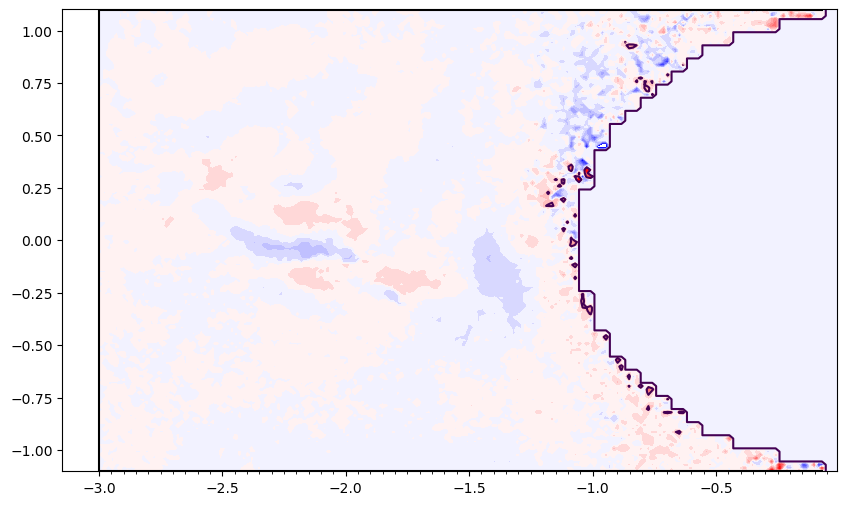

In [4]:
# STEP TWO: read and plot
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/all_ta/"     # Directory with data 
start_time = 46 
t_bound = [48,72]                                               # Start and stop times of this data to be plot
dt = 0.05         

# Plotmode settings
particle_type = "ion"
xlims = [-3,0]#[-3.25,0]
ylims = [-1.,1.]#[-1.25,1.25]
mi_me = 100 # ion to electron mass ratio

'''
PLOTMODES
"rho": density in PIC domain.
    Parameters: particle_type, xlim, ylim

"Delta_rho": Perturbation rho in PIC domain.
    Parameters: particle_type, xlim, ylim

"Bz": Bz in PIC domain.
    Parameters: xlim, ylim

"Bz1": Bz-Bzdip in PIC domain.
    Parameters: xlim, ylim

"Delta_Bz": Perturbation Bz in PIC domain.
    Parameters: xlim, ylim

"ux": Bulk velocity in PIC domain.
    Parameters: particle_type, xlim, ylim

"T": Maxwellian temperature in PIC domain.
    Parameters: particle_type, xlim, ylim

"Delta_T": Perturbation temperature in PIC domain.
    Parameters: particle_type, xlim, ylim

"T_perp_para": Two panel plot of parallel and perpendicular temperature
    Paramters: particle_type, xlim, ylim

'J_inrt_gradp': shows the inertial and grad(p) currents
    Paramters: particle_type, xlim, ylim

"df_tracker": show DFs and track their trajectories, saving a dictionary of their data
    Parameters: xlim, ylim

"along_line": Show many variables along line trajectory
    Parameters: start_loc, stop_loc, var_ls = ["Bz","rhoS1","uxS0","uyS0","uxS1","uyS1","pxxS0","pyyS0","pzzS0","pxxS1","pyyS1","pzzS1"]

'cross_tail': Line plot of total (planetward magnetic) flux transfer rate across tail. Averages over multiple seconds.

'''

plot_preset='df_tracker'
var_ls = ["Bz","rhoS1","uxS0","uyS0","uzS0","uxS1","uyS1","uzS1","pxxS0","pyyS0","pzzS0","pxxS1","pyyS1","pzzS1"]

#RUN
files = get_files(dir,key="3d\_fluid.*\_t\_...\...",read_time = True)
iter = 0
for time in list(files.keys()): 
    print("Plotting t =",time)

    # Get the file and read the data
    file = str(files[time])
    with open(dir+file, 'rb') as f:
        data = pickle.load(f) 

    # PLOT PRESET 'RHO'
    if plot_preset=='rho':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            rho = data["rhoS1"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -1
        vmax = 1
        nlevels = 21 
        levels = np.logspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, rho, levels=levels, cmap='rainbow', norm=LogNorm(), extend='both')
        ax.contour(X, Y, rho, [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax, norm=LogNorm()) 
        clb1.ax.tick_params(labelsize=15)
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('ρ [amu/cc]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+" density at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'Delta_rho'
    if plot_preset=='Delta_rho':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            rho_avg = average_value(["rhoS1"],float(time),-0.5,0.5)["rhoS1"]
            rho = data["rhoS1"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -2
        vmax = 2
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, rho-rho_avg, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, rho, [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('ρ [amu/cc]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$\Delta$ρ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'Bz'
    if plot_preset=='Bz':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        Bz = data["Bz"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = 0
        vmax = 100
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Bz, levels=levels, cmap='rainbow', extend='both')
        ax.contour(X, Y, rho, [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$B_z$ [nT]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z$ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'Bz1'
    if plot_preset=='Bz1':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        Bz = data["Bz"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -50
        vmax = 50
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Bz-Bz_dip(X,Y,Z), levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, data['rhoS1'], [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$B_{z1}$ [nT]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z - B_{z,dip}$ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)


    # PLOT PRESET 'Delta_Bz'
    if plot_preset=='Delta_Bz':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        Bz = data["Bz"]

        # Get time-averaged Bz
        Bz_avg = average_value(["Bz"],float(time),-1,1)["Bz"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -20
        vmax = 20
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Bz-Bz_avg, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, data["rhoS1"], [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$B_z$ [nT]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$\Delta B_z$ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    if plot_preset=='ux':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            ux = data["uxS1"]
        elif particle_type == "electron":
            ux = data["uxS0"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -2000
        vmax = 2000
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, ux, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, data['rhoS1'], [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('v [km/s]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+" x-velocity at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'T'
    if plot_preset=='T':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            n = data["rhoS1"] * 1e6 # convert to SI
            p = (data["pxxS1"]+data["pyyS1"]+data["pzzS1"])/3*1e-9 # convert to SI
        elif particle_type == "electron":
            n = data["rhoS0"] * mi_me * 1e6 # convert to SI
            p = (data["pxxS0"]+data["pyyS0"]+data["pzzS0"])/3*1e-9 # convert to SI

        T = p/n/k_b / 11605 #Convert to eV

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = 2
        vmax = 4.2
        nlevels = 21 
        levels = np.logspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, T, levels=levels, cmap='rainbow', norm = LogNorm(), extend = 'both')
        ax.contour(X, Y, rho, [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax, norm=LogNorm()) 
        clb1.ax.tick_params(labelsize=15)
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('T [eV]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+" temperature at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'Delta_T'
    if plot_preset=='Delta_T':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            n = data["rhoS1"] * 1e6 # convert to SI
            p = (data["pxxS1"]+data["pyyS1"]+data["pzzS1"])/3*1e-9 # convert to SI
            avg = average_value(["rhoS1","pxxS1","pyyS1","pzzS1"],float(time),-0.5,0.5)
            n_avg = avg["rhoS1"] * 1e6
            p_avg = (avg["pxxS1"]+avg["pyyS1"]+avg["pzzS1"])/3*1e-9
            
        elif particle_type == "electron":
            n = data["rhoS0"] * mi_me * 1e6 # convert to SI
            p = (data["pxxS0"]+data["pyyS0"]+data["pzzS0"])/3*1e-9 # convert to SI
            avg = average_value(["rhoS0","pxxS0","pyyS0","pzzS0"],float(time),-1,1)
            n_avg = avg["rhoS0"] * mi_me * 1e6
            p_avg = (avg["pxxS0"]+avg["pyyS0"]+avg["pzzS0"])/3*1e-9

        T = p/n/k_b / 11605 / 1e3 #Convert to keV
        T_avg = p_avg/n_avg/k_b / 11605 / 1e3

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -2
        vmax = 2
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, T-T_avg, levels=levels, cmap='bwr', extend = 'both')
        ax.contour(X, Y, data['rhoS1'], [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax)
        clb1.ax.tick_params(labelsize=15)
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('T [keV]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$\Delta$ "+particle_type+" temperature at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'T_perp_para'
    if plot_preset=='T_perp_para':

        fig, ax = plt.subplots(ncols=2,figsize=(17,5))
        
        if particle_type=="ion":
            pxx = data["pxxS1"]
            pxy = data["pxyS1"]
            pxz = data["pxzS1"]
            pyy = data["pyyS1"]
            pyz = data["pyzS1"]
            pzz = data["pzzS1"]
            rho = data["rhoS1"] # its actually number density
        elif particle_type=="electron":
            pxx = data["pxxS0"]
            pxy = data["pxyS0"]
            pxz = data["pxzS0"]
            pyy = data["pyyS0"]
            pyz = data["pyzS0"]
            pzz = data["pzzS0"]
            rho = data["rhoS0"]*mi_me # 0.01amu/cc electrons is actually 1 electron/cc
        else:
            print("ERROR: invalid particle type!")
    
        # Extract field terms
        Bx = data["Bx"]
        By = data["By"]
        Bz = data["Bz"]
        Ex = data["Ex"]
        Ey = data["Ey"]
        Ez = data["Ez"]
    
        # Compute magnetic unit vector
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
        bx,by,bz = 1/B_mag * [Bx,By,Bz]
    
        # Compute magnetic field unit vectors: u,v,b. u is parallel to ExB direction. v = uxb. We already have b.
        # In the end, our new system will be perp1, perp2, para (u,v,b). See back page of space physics 2024 notebook for derivation, or photos from sep. 4, 2024
        # Compute u first, making sure to normalize
        ux,uy,uz = [Ey*Bz-Ez*By, Ez*Bx-Ex*Bz, Ex*By-Ey*Bx]
        ux,uy,uz = 1/np.sqrt(ux**2+uy**2+uz**2)*[ux,uy,uz]
    
        # Then compute v (already normalized):
        vx,vy,vz = [uy*bz-uz*by, uz*bx-ux*bz, ux*by-uy*bx]
    
        # We now compute the three diagonal pressure components, using e.g. P_para = b . p . b
        P11 = ux*(pxx*ux+pxy*uy+pxz*uz) + uy*(pxy*ux+pyy*uy+pyz*uz) + uz*(pxz*ux+pyz*uy+pzz*uz)
        P22 = vx*(pxx*vx+pxy*vy+pxz*vz) + vy*(pxy*vx+pyy*vy+pyz*vz) + vz*(pxz*vx+pyz*vy+pzz*vz)
        P33 = bx*(pxx*bx+pxy*by+pxz*bz) + by*(pxy*bx+pyy*by+pyz*bz) + bz*(pxz*bx+pyz*by+pzz*bz)
    
        # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
        # See Gurnett+Bhattacharjee "Introduction to Plasma Physics: Kinetic Theory and the Moment Equations" p151
        T_perp = (P11+P11)/2/rho/k_b * 1e-9/1e6/11600# convert from nPa and 1/cm^3
        T_para = (P33)/rho/k_b * 1e-9/1e6/11600 #[eV]
    
        # Plot
        
        #levels = np.logspace(vmin, vmax, nlevels)
        vmin = 2
        vmax = 4.2
        nlevels = 21 
        levels = np.logspace(vmin, vmax, nlevels)
    
        # Plot perp temperature
        cs1 = ax[0].contourf(data["X"],data["Y"],T_perp, cmap='rainbow', levels=levels,extend="both",norm = LogNorm())#,norm = LogNorm(),extend="both")
        ax[0].contour(data["X"],data["Y"],pxx, [0])
        ax[0].plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
        
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)
    
        ax[0].set_xticks(x_major_ticks)
        ax[0].set_xticks(x_minor_ticks, minor=True)
        ax[0].set_yticks(y_major_ticks)
        ax[0].set_yticks(y_minor_ticks, minor=True)
    
        ax[0].grid(which='both')
        ax[0].grid(which='minor', alpha=0.2)
        ax[0].grid(which='major', alpha=0.5)
    
        clb1 = fig.colorbar(cs1, ax=ax[0],norm=LogNorm())  
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()       
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$T_{perp}$ [eV]',fontsize=15)
        
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]",fontsize=15)
        ax[0].set_ylabel("Y [$R_M$]",fontsize=15)
        ax[0].add_patch(plt.Circle((0, 0), np.sqrt(1-np.mean(data["Z"]**2)), color='grey'))
        ax[0].add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(data["Z"]**2)), color='black'))
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].tick_params(axis='both',labelsize=15)
        ax[0].set_title(str("Perpendicular temperature at t ="+"%.2f"%round(float(time),2)+"s"+"\n Particle type: "+particle_type),fontsize=15)
    
        # Plot para temperature
        cs2 = ax[1].contourf(data["X"],data["Y"],T_para, cmap='rainbow',levels=levels,extend="both",norm=LogNorm())#,norm = LogNorm())
        ax[1].contour(data["X"],data["Y"],pxx, [0])
        ax[1].plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
    
        ax[1].set_xticks(x_major_ticks)
        ax[1].set_xticks(x_minor_ticks, minor=True)
        ax[1].set_yticks(y_major_ticks)
        ax[1].set_yticks(y_minor_ticks, minor=True)
    
        ax[1].grid(which='both')
        ax[1].grid(which='minor', alpha=0.2)
        ax[1].grid(which='major', alpha=0.5)
        
        clb2 = fig.colorbar(cs2, ax=ax[1],norm=LogNorm())  
        clb2.locator = LogLocator()
        clb2.formatter = LogFormatterSciNotation()       
        clb2.ax.tick_params(labelsize=15)
        clb2.ax.set_title('$T_{para}$ [eV]',fontsize=15)
        
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]",fontsize=15)
        ax[1].set_ylabel("Y [$R_M$]",fontsize=15)
        ax[1].add_patch(plt.Circle((0, 0), np.sqrt(1-np.mean(data["Z"]**2)), color='grey'))
        ax[1].add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(data["Z"]**2)), color='black'))
        ax[1].set_xlim(xlims)
        ax[1].set_ylim(ylims)
        ax[1].tick_params(axis='both',labelsize=15)
        ax[1].set_title(str("Parallel temperature at t ="+"%.2f"%round(float(time),2)+"\n Particle type: "+particle_type),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

    # PLOT PRESET 'J_inrt_gradp'
    if plot_preset=='J_inrt_gradp':
    
        fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(20,7))
    
        # Slice out current sheet, get velocity data, and derivaties of total pressure
        n = data["rhoS1"]*1e6
        dp_dx,dp_dy,dp_dz = (data["dp_dx"],data["dp_dy"],data["dp_dz"]) # nPa/m
    
        Bx,By,Bz = (data["Bx"],data["By"],data["Bz"]) #nT
        Jx,Jy,Jz = (data["Jx"],data["Jy"],data["Jz"]) #micro A/m^2
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
    
        # COmpute the grad_P current
        prefactor = 1/(B_mag*1e-9)**2 #SI
        prefactor[np.isnan(prefactor)] = 0
    
        J_gradP_x = prefactor * (1e-18) * (By*dp_dz - Bz*dp_dy)
        J_gradP_y = prefactor * (1e-18) * (Bz*dp_dx - Bx*dp_dz)
        J_gradP_z = prefactor * (1e-18) * (Bx*dp_dy - By*dp_dx)
    
        # compute velocity time derivaties
        if particle_type=="ion":
            dv_dts = compute_dt(["uxS1","uyS1","uzS1"],time)
            dux_dt = dv_dts['uxS1']
            duy_dt = dv_dts['uyS1']
            duz_dt = dv_dts['uzS1']
            m_s = m_p
        elif particle_type=="electron":
            dv_dts = compute_dt(["uxS0","uyS0","uzS0"],time)
            dux_dt = dv_dts['uxS0']
            duy_dt = dv_dts['uyS0']
            duz_dt = dv_dts['uzS0']
            m_s = m_p/mi_me
        
        J_inrt_x = (n*m_s) * prefactor * (By*duz_dt - Bz*duy_dt)*1e3*1e-9
        J_inrt_y = (n*m_s) * prefactor * (Bz*dux_dt - Bx*duz_dt)*1e3*1e-9
        J_inrt_z = (n*m_s) * prefactor * (Bx*duy_dt - By*dux_dt)*1e3*1e-9
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.5)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    
        # J_inrt plot
        J_ls = [Jx,Jy,Jz]
        plot_ls = [J_inrt_x,J_inrt_y,J_inrt_z]
        vmin = -1.2
        vmax = 1.2
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        
        for i in range(len(plot_ls)):
            inner = plt.Circle((0, 0), 0.8, color='black')
            outer = plt.Circle((0, 0), 1, color='grey')
    
            plot = ax[0,i].contourf(data['X'], data['Y'], (plot_ls[i])*1e6, levels=levels, cmap='bwr',extend='both') #(plot_ls[i]-J_ls[i])*1e6
            ax[0,i].contour(data['X'], data['Y'], n, [0])
            ax[0,i].plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
    
            #clb = fig.colorbar(plot, ax=ax[i])  
            #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
        
            ax[0,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            ax[0,i].set_xlabel("X [$R_M$]",fontsize=15)
            ax[0,i].set_ylabel("Y [$R_M$]",fontsize=15)
            ax[0,i].add_patch(outer)
            ax[0,i].add_patch(inner)
            ax[0,i].set_xlim(xlims)
            ax[0,i].set_ylim(ylims)
            ax[0,i].set_xticks(x_major_ticks)
            ax[0,i].set_xticks(x_minor_ticks, minor=True)
            ax[0,i].set_yticks(y_major_ticks)
            ax[0,i].set_yticks(y_minor_ticks, minor=True)
            ax[0,i].grid(which='both')
            ax[0,i].grid(which='minor', alpha=0.2)
            ax[0,i].grid(which='major', alpha=0.5)
            ax[0,i].tick_params(axis='both',labelsize=15)
            ax[0,i].set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ at t="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
            #ax[0,i].set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}-J_{"+str(["x","y","z"][i])+"}$ at t="+str(round(float(time),2))+"s"),fontsize=15)
    
        fig.subplots_adjust(right=0.8)
        cbar1 = fig.colorbar(plot, ax=ax[0,:], shrink=0.8)
        cbar1.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=15)
        cbar1.ax.tick_params(labelsize=15)
        
        #J_gradP plot
        plot_ls = [J_gradP_x,J_gradP_y,J_gradP_z]
        vmin = -1.2
        vmax = 1.2
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        
        for i in range(len(plot_ls)):
            inner = plt.Circle((0, 0), 0.8, color='black')
            outer = plt.Circle((0, 0), 1, color='grey')
    
            plot = ax[1,i].contourf(data['X'], data['Y'], (plot_ls[i])*1e6, levels=levels, cmap='bwr',extend='both')
            ax[1,i].contour(data['X'], data['Y'], n, [0])
            ax[1,i].plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
            
            #clb = fig.colorbar(plot, ax=ax[i])  
            #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
        
            ax[1,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            ax[1,i].set_xlabel("X [$R_M$]",fontsize=15)
            ax[1,i].set_ylabel("Y [$R_M$]",fontsize=15)
            ax[1,i].add_patch(outer)
            ax[1,i].add_patch(inner)
            ax[1,i].set_xlim(xlims)
            ax[1,i].set_ylim(ylims)
            ax[1,i].set_xticks(x_major_ticks)
            ax[1,i].set_xticks(x_minor_ticks, minor=True)
            ax[1,i].set_yticks(y_major_ticks)
            ax[1,i].set_yticks(y_minor_ticks, minor=True)
            ax[1,i].grid(which='both')
            ax[1,i].grid(which='minor', alpha=0.2)
            ax[1,i].grid(which='major', alpha=0.5)
            ax[1,i].tick_params(axis='both',labelsize=15)
            ax[1,i].set_title(str("$J_{grad(P),"+str(["x","y","z"][i])+"}$ at t="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
            #ax[1,i].set_title(str("$J_{grad(P),"+str(["x","y","z"][i])+"}-J_{"+str(["x","y","z"][i])+"}$ at t="+str(round(float(time),2))+"s"),fontsize=15)
    
        cbar2 = fig.colorbar(plot, ax=ax[1, :], shrink=0.8)
        cbar2.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=15)
        cbar2.ax.tick_params(labelsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)


    # PLOT PRESET 'df_tracker'
    if plot_preset=='df_tracker':

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step

        fig, ax = plt.subplots(ncols=1,figsize=(10,6))

        # Unpack data
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        Bx = data["Bx"] 
        By = data["By"] 
        Bz = data["Bz"] 
        n = data["rhoS1"] * 1e6 # convert to SI
        pe = (data["pxxS0"]+data["pyyS0"]+data["pzzS0"])/3*1e-9 # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = data["uxS1"] 
        uiy = data["uyS1"] 
        uex = data["uxS0"] 
        uey = data["uyS0"] 
        uez = data["uyS0"] 
        # Compute convective electric field
        E_convx = -(uey*Bz-uez*By)*1000*1e-9 # Convert to V/m ie SI
        E_convy = -(uez*Bx-uex*Bz)*1000*1e-9
        E_convz = -(uex*By-uey*Bx)*1000*1e-9

        # Compute average values of Bz in the 5seconds preceeding the current time
        Bz_avg = average_value(["Bz"],float(time),-2,0)["Bz"]
        avg = average_value(["rhoS0","pxxS0","pyyS0","pzzS0"],float(time),-2,0)
        n_avg = avg["rhoS0"] * mi_me * 1e6
        p_avg = (avg["pxxS0"]+avg["pyyS0"]+avg["pzzS0"])/3*1e-9
        Te_avg = p_avg/n_avg/k_b / 11605 / 1e3

        # Compute time derivs of velocities
        dv_dts = compute_dt(["uxS1","uyS1","uzS1","uxS0","uyS0","uzS0"],time)

        # Compute DF metric
        #metric = (Te-Te_avg)
        #metric[metric<0] = 0 
        #metric = metric*(Bz-Bz_avg)
        metric = (Bz-Bz_avg)
    
        # Plot
        cs1 = ax.contourf(X,Y,(Bz-Bz_avg), cmap='bwr',levels=np.linspace(-40,40,21))
        ax.contour(X, Y, n, [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
        
        # Trim down DF search area
        df_xlims = [-2.95,-0.5]
        df_ylims = [-1.00,1]
        min_value = 10 #nT * keV
        min_size = 10
        dx = 1/64

        # Trim all the variables to the search area
        x0 = np.min(X)
        y0 = np.min(Y)
        dx = 1/64
        xi_min = int((df_xlims[0]-x0)/dx)
        xi_max = int((df_xlims[1]-x0)/dx)
        yi_min = int((df_ylims[0]-y0)/dx)
        yi_max = int((df_ylims[1]-y0)/dx)
        X = X[yi_min:yi_max,xi_min:xi_max]
        Y = Y[yi_min:yi_max,xi_min:xi_max]
        Bx = Bx[yi_min:yi_max,xi_min:xi_max]
        By = By[yi_min:yi_max,xi_min:xi_max]
        Bz = Bz[yi_min:yi_max,xi_min:xi_max]
        pe = pe[yi_min:yi_max,xi_min:xi_max]
        Te = Te[yi_min:yi_max,xi_min:xi_max]
        n = n[yi_min:yi_max,xi_min:xi_max]
        uix = uix[yi_min:yi_max,xi_min:xi_max]
        uiy = uiy[yi_min:yi_max,xi_min:xi_max]
        uex = uex[yi_min:yi_max,xi_min:xi_max]
        uey = uey[yi_min:yi_max,xi_min:xi_max]
        E_convx = E_convx[yi_min:yi_max,xi_min:xi_max]
        E_convy = E_convy[yi_min:yi_max,xi_min:xi_max]
        E_convz = E_convz[yi_min:yi_max,xi_min:xi_max]
        dp_dx = data['dp_dx'][yi_min:yi_max,xi_min:xi_max] #nPa/m
        dp_dy = data['dp_dy'][yi_min:yi_max,xi_min:xi_max]
        dp_dz = data['dp_dz'][yi_min:yi_max,xi_min:xi_max]
        duix_dt = dv_dts['uxS1'][yi_min:yi_max,xi_min:xi_max] #km/s /s
        duiy_dt = dv_dts['uyS1'][yi_min:yi_max,xi_min:xi_max]
        duiz_dt = dv_dts['uzS1'][yi_min:yi_max,xi_min:xi_max]
        duex_dt = dv_dts['uxS0'][yi_min:yi_max,xi_min:xi_max]
        duey_dt = dv_dts['uyS0'][yi_min:yi_max,xi_min:xi_max]
        duez_dt = dv_dts['uzS0'][yi_min:yi_max,xi_min:xi_max]
        metric = metric[yi_min:yi_max,xi_min:xi_max]
    
        ax.contour(X,Y,metric,[min_value])
        
        # Code from UM GPT to label regions
        # Create boolean mask where Z exceeds z_0
        mask = metric > min_value
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        labeled, num_features = label(mask, structure=structure)
        
        # Find all the DF regions in this time slice
        new_df_dict = {}
        count=1
        for feature_num in range(1, num_features + 1):
            region = (labeled == feature_num)
            # Remove regions that are too small
            if len(X[region])>min_size:
                new_df_dict[count] = (X[region], Y[region])
                count+=1
    
        print("Found",len(new_df_dict.keys()),"DFs at this time")
    
        # Compare to previous df_dict, if any, and relabel DFs for continuity
    
        if df_dict is not None and len(new_df_dict.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            next_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(new_df_dict.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(new_df_dict[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(new_df_dict[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Sometimes a weird error happens where we have new DFs but none overlap and we have an empty matrix.. this is a hotfix for that case:
            #if len(overlap_masks)==0:
            #    df_dict = new_df_dict   
            #else:
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Code to do this from umgpt
            def remove_duplicate_rows(arr):
                seen = set()
                filtered_rows = []
                for row in arr:
                    if row[0] not in seen:
                        filtered_rows.append(row)
                        seen.add(row[0])
                return np.array(filtered_rows)
    
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(new_df_dict.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            print("NEW DF KEY   OLD DF KEY   MATCH")
            print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    # Check to see if this formed too close to the planet
                    r = np.mean(np.sqrt(new_df_dict[matrix[i,0]][0]**2+new_df_dict[matrix[i,0]][1]**2))
                    if r>1.25:
                        next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                elif (matrix[i,1] not in next_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    next_df_dict[matrix[i,1]] = new_df_dict[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(next_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    next_df_dict[new_df_key] = next_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = next_df_dict   
        else:
            df_dict = new_df_dict    
    
        # Show the regions
        color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]
        for key in df_dict.keys():
            X_region, Y_region = df_dict[key]
            ax.plot(X_region, Y_region, 'o', alpha=0.7, color = color_ls[key%10], label=str('DF '+str(key)))
            
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy",'uex',"uey",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Bz_max",'area'])
            new_row = np.zeros(27)
            # Now we iterate over each coordinate associated with this DF
            Bz_max_ls = []
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix]
                new_row[2] = new_row[2] + Y[iy,ix]
                new_row[3] = new_row[3] + Z[iy,ix]
                new_row[4] = new_row[4] + Bx[iy,ix]
                new_row[5] = new_row[5] + By[iy,ix]
                new_row[6] = new_row[6] + Bz[iy,ix]
                new_row[7] = new_row[7] + Te[iy,ix]
                new_row[8] = new_row[8] + n[iy,ix]
                new_row[9] = new_row[9] + uix[iy,ix]
                new_row[10] = new_row[10] + uiy[iy,ix]
                new_row[11] = new_row[11] + uex[iy,ix]
                new_row[12] = new_row[12] + uey[iy,ix]
                new_row[13] = new_row[13] + E_convx[iy,ix]
                new_row[14] = new_row[14] + E_convy[iy,ix]
                new_row[15] = new_row[15] + E_convz[iy,ix]
                new_row[16] = new_row[16] + dp_dx[iy,ix]
                new_row[17] = new_row[17] + dp_dy[iy,ix]
                new_row[18] = new_row[18] + dp_dz[iy,ix]
                new_row[19] = new_row[19] + (n[iy,ix])*m_p/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)*1e-9) * (By[iy,ix]*duez_dt[iy,ix]-Bz[iy,ix]*duey_dt[iy,ix])*1e3 #A/m^2
                new_row[20] = new_row[20] + (n[iy,ix])*m_p/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)*1e-9) * (Bz[iy,ix]*duex_dt[iy,ix]-Bx[iy,ix]*duez_dt[iy,ix])*1e3 #A/m^2
                new_row[21] = new_row[21] + (n[iy,ix])*m_p/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)*1e-9) * (Bx[iy,ix]*duey_dt[iy,ix]-By[iy,ix]*duex_dt[iy,ix])*1e3 #A/m^2
                new_row[22] = new_row[22] + 1/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)) * (By[iy,ix]*dp_dz[iy,ix]+Bz[iy,ix]*dp_dy[iy,ix]) #A/m^2
                new_row[23] = new_row[23] + 1/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)) * (Bz[iy,ix]*dp_dx[iy,ix]+Bx[iy,ix]*dp_dz[iy,ix]) #A/m^2
                new_row[24] = new_row[24] + 1/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)) * (Bx[iy,ix]*dp_dy[iy,ix]+By[iy,ix]*dp_dx[iy,ix]) #A/m^2

                Bz_max_ls.append(Bz[iy,ix]) # Save all the Bz values to find the max in the DF
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            new_row[25] = np.max(Bz_max_ls) # Set the 9th column to the max Bz
            new_row[26] = (1/64)**2*(i+1) # Set the last row to the area
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe
    
            # Show a trace of each current DF's path
            ax.plot(temp["X"],temp["Y"], color = color_ls[key%10])
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)
    
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
    
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
    
        clb1 = fig.colorbar(cs1, ax=ax)#,norm=LogNorm())  
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()       
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$\delta B_z$ [nT]',fontsize=15)
        
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.add_patch(plt.Circle((0, 0), np.sqrt(1-0.2**2), color='grey'))
        ax.add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-0.2**2), color='black'))
        ax.tick_params(axis='both',labelsize=15)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("DFs at t ="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
        #ax.legend(loc='upper right',fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

    # PLOT PRESET 'along_line'
    if plot_preset=='along_line':

        # Line settings
        num_points = 200 # Number of points for each line
        line_start = [-2,0] # Coordinates of start
        line_end = [-0.6,-1] # Coordinates of end
        line_width = 0.02 # y extent of line
        num_lines = 15 # How many lines to trace across y (min 2)

        # Compute averages
        avg = average_value(var_ls,float(time),-1,1)

        # Subtract averages
        avg_data = {"X":data["X"],"Y":data["Y"],"Bz":data["Bz"]-avg["Bz"],"rhoS1":data["rhoS1"]-avg["rhoS1"]}

        # Compute derived quantities
        Te = ((data["pxxS0"]+data["pyyS0"]+data["pzzS0"])/3*1e-9) / (data["rhoS1"]*1e6) / k_b / 11605 # eV
        Te_avg = ((avg["pxxS0"]+avg["pyyS0"]+avg["pzzS0"])/3*1e-9) / (avg["rhoS1"]*1e6) / k_b / 11605 # eV
        Ti = ((data["pxxS1"]+data["pyyS1"]+data["pzzS1"])/3*1e-9) / (data["rhoS1"]*1e6) / k_b / 11605 # eV
        Ti_avg = ((avg["pxxS1"]+avg["pyyS1"]+avg["pzzS1"])/3*1e-9) / (avg["rhoS1"]*1e6) / k_b / 11605 # eV
        ue = np.sqrt((data["uxS0"])**2+(data["uyS0"])**2+(data["uzS0"])**2)
        ue_avg = np.sqrt((avg["uxS0"])**2+(avg["uyS0"])**2+(avg["uzS0"])**2)
        ui = np.sqrt((data["uxS1"])**2+(data["uyS1"])**2+(data["uzS1"])**2)
        ui_avg = np.sqrt((avg["uxS1"])**2+(avg["uyS1"])**2+(avg["uzS1"])**2)
        avg_data["Te"] = Te-Te_avg
        avg_data["Ti"] = Ti-Ti_avg
        avg_data["ui"] = ui-ui_avg
        avg_data["ue"] = ue-ue_avg

         # Extract each line, from y0-width/2 to y0+width/2
        line_ls = []
        for i in range(num_lines):
            line_ls.append(extract_line(avg_data,list(map(add, line_start, [0,-line_width/2 + line_width/(num_lines-1)*i])),list(map(add, line_end, [0,-line_width/2 + line_width/(num_lines-1)*i]))))
    
        # Compute average value and std for the set of parallel lines
        line_avg = {}
        line_std = {}
        for var in list(avg_data.keys()):
            line_array = np.zeros((num_points,num_lines))
            for i in range(num_lines):
                line_array[:,i] = line_ls[i][var]
            line_avg[var] = np.mean(line_array, axis=1)
            line_std[var] = np.std(line_array, axis=1)
        line_avg["s"] = np.sqrt((line_avg["X"]-line_avg["X"][0])**2+(line_avg["Y"]-line_avg["Y"][0])**2)*R_M/1e3

        fig = plt.figure(figsize=(12,18))
        gs = fig.add_gridspec(6, 1, hspace=0)
        ax = gs.subplots(sharex='col')
        #fig,ax = plt.subplots(nrows = 6, figsize=(12,18),sharex='col')
    
        # Subplot 0: Bz
        ax[0].plot(line_avg["s"],line_avg["Bz"],color="black")
        ax[0].fill_between(line_avg["s"],line_avg["Bz"]-line_std["Bz"],line_avg["Bz"]+line_std["Bz"],color="black",alpha=0.2)
        ax[0].set_ylabel("$\delta B_z$ [nT]",fontsize=15)
        ax[0].set_ylim(-30,30)
    
        # Subplot 1: n
        ax[1].plot(line_avg["s"],line_avg["rhoS1"],color="black")
        ax[1].fill_between(line_avg["s"],line_avg["rhoS1"]-line_std["rhoS1"],line_avg["rhoS1"]+line_std["rhoS1"],color="black",alpha=0.2)
        ax[1].set_ylabel("$\delta n$ [cm$^{-3}$]",fontsize=15)
        ax[1].set_ylim(-2.5,2.5)
    
        # Subplot 2: u_ion
        ax[2].plot(line_avg["s"],line_avg["ui"],color="black")
        ax[2].fill_between(line_avg["s"],line_avg["ui"]-line_std["ui"],line_avg["ui"]+line_std["ui"],color="black",alpha=0.2)
        ax[2].set_ylabel("$\delta u_{i}$ [km/s]",fontsize=15)
        ax[2].set_ylim(-600,600)
    
        # Subplot 3: u_ele
        ax[3].plot(line_avg["s"],line_avg["ue"],color="black")
        ax[3].fill_between(line_avg["s"],line_avg["ue"]-line_std["ue"],line_avg["ue"]+line_std["ue"],color="black",alpha=0.2)
        ax[3].set_ylabel("$\delta u_{e}$ [km/s]",fontsize=15)
        ax[3].set_ylim(-5000,5000)
    
        # Subplot 4: T_i
        ax[4].plot(line_avg["s"],line_avg["Ti"],color="black")
        ax[4].fill_between(line_avg["s"],line_avg["Ti"]-line_std["Ti"],line_avg["Ti"]+line_std["Ti"],color="black",alpha=0.2)
        ax[4].set_ylabel("$\delta T_{i}$ [eV]",fontsize=15)
        ax[4].set_ylim(-5000,5000)
    
        # Subplot 4: T_e
        ax[5].plot(line_avg["s"],line_avg["Te"],color="black")
        ax[5].fill_between(line_avg["s"],line_avg["Te"]-line_std["Te"],line_avg["Te"]+line_std["Te"],color="black",alpha=0.2)
        ax[5].set_ylabel("$\delta T_{e}$ [eV]",fontsize=15)
        ax[5].set_ylim(-5000,5000)
        ax[5].set_xlabel("Distance [km/s]",fontsize=15)
    
        for j in [0,1,2,3,4,5]:
            ax[j].set_xlim(0,np.max(line_avg["s"]))
            #ax[j].set_xlabel("Distance [km/s]",fontsize=15)
            ax[j].tick_params(axis='both',labelsize=15)
            ax[j].grid()

        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close()

    # PLOT PRESET 'cross_tail'
    if plot_preset=='cross_tail':

        # Compute averages
        avg = average_value(["uxS0","uzS0","uxS1","uzS1","Bx","Bz","Ey"],float(time),0,0)

        # Compute e-field
        Ey = avg["Ey"]*1e-6 # V/m
        Eyi = -(avg["uzS1"]*avg["Bx"]-avg["uxS1"]*avg["Bz"])*1e3*1e-9 # V/m
        Eye = -(avg["uzS0"]*avg["Bx"]-avg["uxS0"]*avg["Bz"])*1e3*1e-9

        # Line settings
        num_points = 40 # Number of points for each line 
        num_cuts = 40 # How many cross tail averages to make
        x_start = -2.95 # Where to start taking cross tail cuts from
        x_end = -1.1 # Where to stop
        
        flux_rate = [] # (Magnetic) flux transfer rate from FLEKS E field
        ion_flux_rate = [] # (Magnetic) flux transfer rate from ion convection E field
        electron_flux_rate = [] # (Magnetic) flux transfer rate from electron convection E field
        ux = [] # Average electron velocity
        '''
        x_points = np.linspace(x_start,x_end,num_cuts)
        # Loop over each line (ie each cross tail slice)
        for xi in x_points:
            line_start = [xi,-1] # Coordinates of start
            line_end = [xi,1] # Coordinates of end
            line_width = 0.001 # y extent of line
            num_lines = 2 # How many lines to trace across y (min 2)

             # Extract each line, from y0-width/2 to y0+width/2
            line_ls = []
            for i in range(num_lines):
                line_ls.append(extract_line({"X":data["X"],"Y":data["Y"],"Eyi":Eyi,"Eye":Eye,"Ey":Ey,"uxS0":avg["uxS0"]},list(map(add, line_start, [0,-line_width/2 + line_width/(num_lines-1)*i])),list(map(add, line_end, [0,-line_width/2 + line_width/(num_lines-1)*i]))))
    
            # We only need the middle of the 3 lines
            line = line_ls[1]
    
            # Line integral
            flux_rate.append(np.sum(line["Ey"])*(line["Y"][1]-line["Y"][0])*R_M*1e-6) #MWb/s
            ion_flux_rate.append(np.sum(line["Eyi"])*(line["Y"][1]-line["Y"][0])*R_M*1e-6)
            electron_flux_rate.append(np.sum(line["Eye"])*(line["Y"][1]-line["Y"][0])*R_M*1e-6)
            ux.append(np.mean(line["uxS0"]))
        '''
        x_points = data["X"][0,:]
        for xi in range(len(x_points)):
            flux_rate.append(np.sum(Ey[:,xi])*(data["Y"][1,0]-data["Y"][0,0])*R_M*1e-6) #MWb/s
            ion_flux_rate.append(np.sum(Eyi[:,xi])*(data["Y"][1,0]-data["Y"][0,0])*R_M*1e-6)
            electron_flux_rate.append(np.sum(Eye[:,xi])*(data["Y"][1,0]-data["Y"][0,0])*R_M*1e-6)
            ux.append(np.mean(data["uxS0"][:,xi]))
        fig,ax = plt.subplots(figsize=(10,5))
    
        ax.plot(x_points,flux_rate,label="$E$",color="black")
        ax.plot(x_points,ion_flux_rate,label="$E_{conv,i}$",color="black",linestyle="dashed")
        ax.plot(x_points,electron_flux_rate,label="$E_{conv,e}$",color="black",linestyle='dotted')
        ax2 = ax.twinx()
        ax2.plot(x_points,ux,color="red")
    
        ax.set_xlabel("$X$ [$R_M$]",fontsize=15)
        ax.set_ylabel("Flux transfer rate [MWb/s]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.grid()
        ax.legend(fontsize=15,loc='upper right')
        ax.set_ylim(0,0.1)

        ax2.set_ylabel("Cross-tail average electron $u_x$ [km/s]",fontsize=15,color="red")
        ax2.xaxis.label.set_color('red')
        ax2.tick_params(axis ='y', labelcolor = "red",labelsize=15) 
        ax2.set_ylim(-2000,2000)
        
        ax.set_xlim(x_start,x_end)
        ax.set_title(str("Flux transport at t ="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
        
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close()
    
    
         
    iter += 1



In [19]:
len(unfiltered_matrix)

1

In [10]:
f

<_io.BufferedReader name='/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/all_ta/3d_fluid_region0_0_t00000101_n00011051_amrex_csdata_t_061.95'>

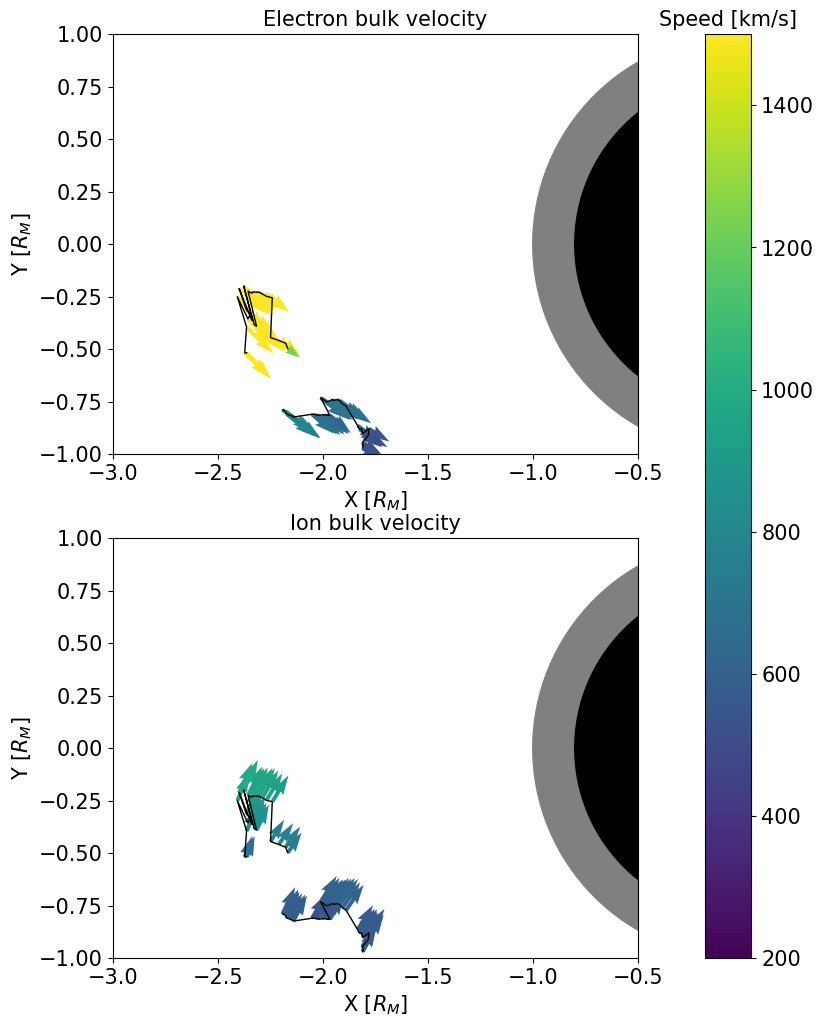

In [6]:
# PLOT TOTAL DF data

fig,ax = plt.subplots(nrows = 2, figsize=(20,12))
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        ax[0].plot(df_data[key]["X"],df_data[key]["Y"], color='black', lw = 1)
        #ax[0].scatter(df_data[key]["X"],df_data[key]["Y"],s=1e3*df_data[key]["area"],c="black")#,vmin=0,vmax=1000)
        ax[1].plot(df_data[key]["X"],df_data[key]["Y"], color='black', lw = 1)
        #ax[1].scatter(df_data[key]["X"],df_data[key]["Y"],s=1e3*df_data[key]["area"],c="black")#,vmin=0,vmax=1000)
        ue = ax[0].quiver(df_data[key]["X"],df_data[key]["Y"],df_data[key]["uex"],df_data[key]["uey"],np.sqrt(df_data[key]["uex"]**2+df_data[key]["uey"]**2),
                       cmap='viridis',clim=[200,1500])
        ui = ax[1].quiver(df_data[key]["X"],df_data[key]["Y"],df_data[key]["uix"],df_data[key]["uiy"],np.sqrt(df_data[key]["uix"]**2+df_data[key]["uiy"]**2),
                          cmap='viridis',clim=[200,1500])
        #s = 500*data[key]["area"],

for i in [0,1]:
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    ax[i].add_patch(outer)
    ax[i].add_patch(inner)
    ax[i].set_ylim(-1,1)
    ax[i].set_xlim(-3,-0.5)
    ax[i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[i].tick_params(axis='both',labelsize=15)
    ax[i].set_xlabel("X [$R_M$]",fontsize=15)
    ax[i].set_ylabel("Y [$R_M$]",fontsize=15)
ax[0].set_title("Electron bulk velocity",fontsize=15)
ax[1].set_title("Ion bulk velocity",fontsize=15)
fig.subplots_adjust(right=0.8)
cbar1 = fig.colorbar(ue, ax=ax[:])
cbar1.ax.tick_params(labelsize=15)
cbar1.ax.set_title('Speed [km/s]',fontsize=15)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_ion_electron_velocity.png'),bbox_inches='tight',dpi = 300)

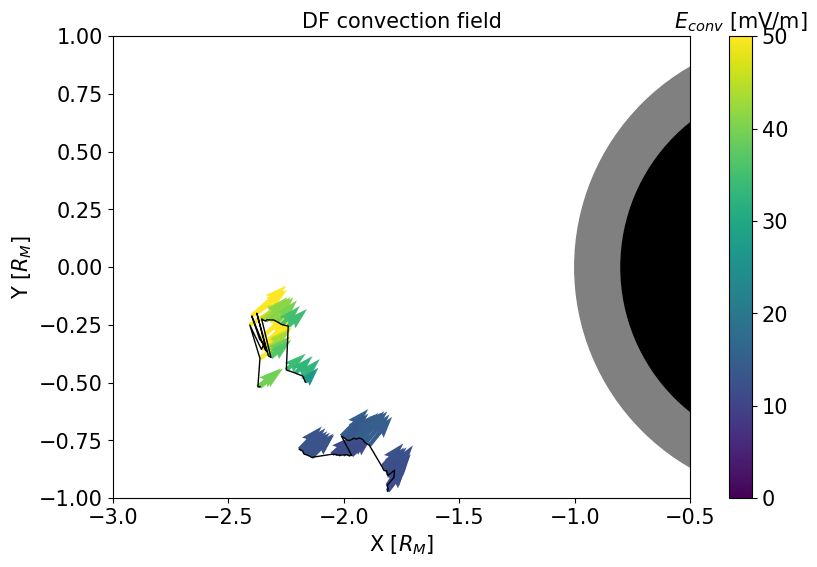

In [7]:
# PLOT TOTAL DF data

fig,ax = plt.subplots(ncols = 1, figsize=(10,6))
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        ax.plot(df_data[key]["X"],df_data[key]["Y"], color='black', lw = 1)
        E_conv = ax.quiver(df_data[key]["X"],df_data[key]["Y"],df_data[key]["E_convx"],df_data[key]["E_convy"],
                           np.sqrt(df_data[key]["E_convx"]**2+df_data[key]["E_convy"]**2)*1e3,
                       cmap='viridis',clim=[0,50])
        #s = 500*data[key]["area"],

inner = plt.Circle((0, 0), 0.8, color='black')
outer = plt.Circle((0, 0), 1, color='grey')
ax.add_patch(outer)
ax.add_patch(inner)
ax.set_ylim(-1,1)
ax.set_xlim(-3,-0.5)
ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
ax.tick_params(axis='both',labelsize=15)
ax.set_xlabel("X [$R_M$]",fontsize=15)
ax.set_ylabel("Y [$R_M$]",fontsize=15)
ax.set_title("DF convection field",fontsize=15)
cbar1 = fig.colorbar(E_conv, ax=ax)
cbar1.ax.tick_params(labelsize=15)
cbar1.ax.set_title('$E_{conv}$ [mV/m]',fontsize=15)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_convection_field.png'),bbox_inches='tight',dpi = 300)

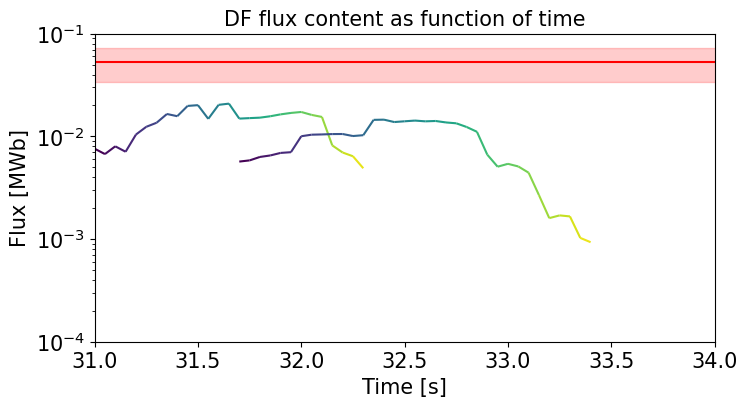

In [10]:
fig,ax = plt.subplots(figsize=(8,4))
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        #ax.plot(df_data[key]["time"],df_data[key]["Bz"]*df_data[key]["area"]*R_M**2*1e-9/1e6,c="black")
        #plot = ax.scatter(df_data[key]["time"],df_data[key]["Bz"]*df_data[key]["area"]*R_M**2*1e-9/1e6,c=(df_data[key]["time"]-df_data[key]["time"][0]))
        x = df_data[key]["time"]
        y = df_data[key]["Bz"]*df_data[key]["area"]*R_M**2*1e-9/1e6
        z = (df_data[key]["time"]-df_data[key]["time"][0])
        # Create a set of line segments so that each segment is colored separately
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        cmap = plt.get_cmap('viridis')  # You can choose any colormap you like
        norm = plt.Normalize(z.min(), z.max())
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Set the values used for colormapping
        lc.set_array(z)
        
        ax.add_collection(lc)

ax.set_title("DF flux content as function of time",fontsize=15)
ax.set_xlabel("Time [s]",fontsize=15)
ax.set_ylabel("Flux [MWb]",fontsize=15)
ax.fill_between([-100,100], [0.034,0.034],[0.072,0.072],alpha = 0.2,color = "red")
ax.plot([-100,100],[0.053,0.053],color='red',label='Dewey et al. (2020)')
#ax.fill_between([-100,100], [0.002,0.002],[0.011,0.011],alpha = 0.2,color = "blue")
#ax.plot([-100,100],[0.002,0.002],color='blue',label='DiBraccio et al. (2015)')
ax.set_yscale("log")
ax.tick_params(axis='both',labelsize=15)
ax.set_xlim(t_bound[0],t_bound[1])
ax.set_ylim(1e-4,0.1)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_flux_content.png'),bbox_inches='tight',dpi = 300)
#ax.set_xscale("log")
#ax.set_yscale("log")

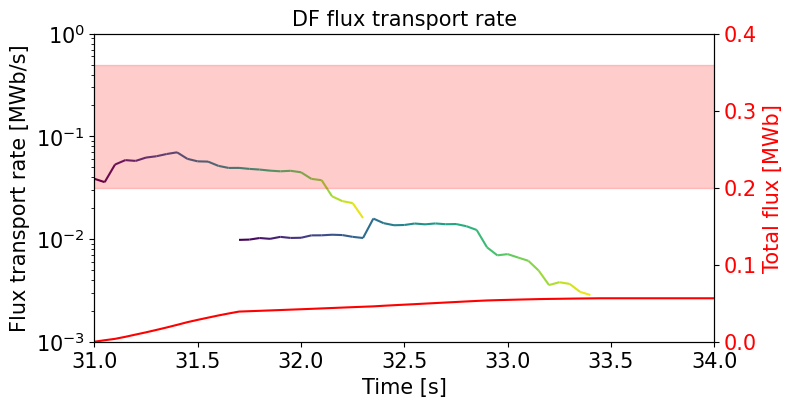

In [12]:
#Plot the radial flux transport rate as E_conv \cdot -rho_hat

fig,ax = plt.subplots(figsize=(8,4))

# Declare arrays to save total flux accumulated
times = np.linspace(t_bound[0],t_bound[1],int((t_bound[1]-t_bound[0])/dt)+1)
total_flux = np.zeros_like(times)

for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        x = df_data[key]["time"] # horizontal axis data
        rho = np.sqrt(df_data[key]["X"]**2+df_data[key]["Y"]**2) # Axial distance
        #E_convrho = (-df_data[key]["E_convx"] * df_data[key]["X"] - df_data[key]["E_convy"] * df_data[key]["Y"])/rho # Convective efield dotted into axial direction
        E_convrho = np.sqrt(df_data[key]["E_convx"]**2 + df_data[key]["E_convy"]**2)  # Convective efield dotted into axial direction
        width = 2*np.sqrt(df_data[key]["area"]*R_M**2/np.pi) # Assuming DF is circle, find diameter
        y = width * E_convrho/1e6 # Flux transport rate in MWb / sec 
        z = (df_data[key]["time"]-df_data[key]["time"][0])
        # Create a set of line segments so that each segment is colored separately
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        cmap = plt.get_cmap('viridis')  # You can choose any colormap you like
        norm = plt.Normalize(z.min(), z.max())
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Set the values used for colormapping
        lc.set_array(z)
        
        ax.add_collection(lc)

        # Save flux to runnning total
        start_i = np.where(np.abs(times-df_data[key]["time"][0])<0.01)[0].item()
        for j in range(len(x)):
            total_flux[start_i+j+1] = total_flux[start_i+j] + dt*y[j]
        for k in range(start_i+j+1,len(times)-1):
            total_flux[k+1] = total_flux[k]



ax.set_title("DF flux transport rate",fontsize=15)
ax2 = ax.twinx()
ax2.fill_between([-100,100], [0.2,0.2],[0.36,0.36],alpha = 0.2,color = "red")
ax2.plot(times,total_flux,color='red')
ax.set_yscale("log")
ax.tick_params(axis='both',labelsize=15)
ax2.tick_params(axis='both',labelsize=15)
ax.set_xlim(t_bound[0],t_bound[1])
ax.set_ylim(0.001,1)
ax2.set_ylim(0,0.4)

ax.set_xlabel("Time [s]",fontsize=15)
ax.set_ylabel("Flux transport rate [MWb/s]",fontsize=15)
ax2.set_ylabel("Total flux [MWb]",fontsize=15,color="red")
ax2.xaxis.label.set_color('red')
ax2.tick_params(axis ='y', labelcolor = "red",labelsize=15) 

fig.savefig(str(dir[:-1]+"_plots/"+'DF_flux_transport_rate.png'),bbox_inches='tight',dpi = 300)
#ax.set_xscale("log")
#ax.set_yscale("log")

In [73]:
np.where(np.abs(times-28.95)<0.01)
#df_data[key]["time"][0]
#np.where(times==df_data[key]["time"][0])
#times

(array([219]),)

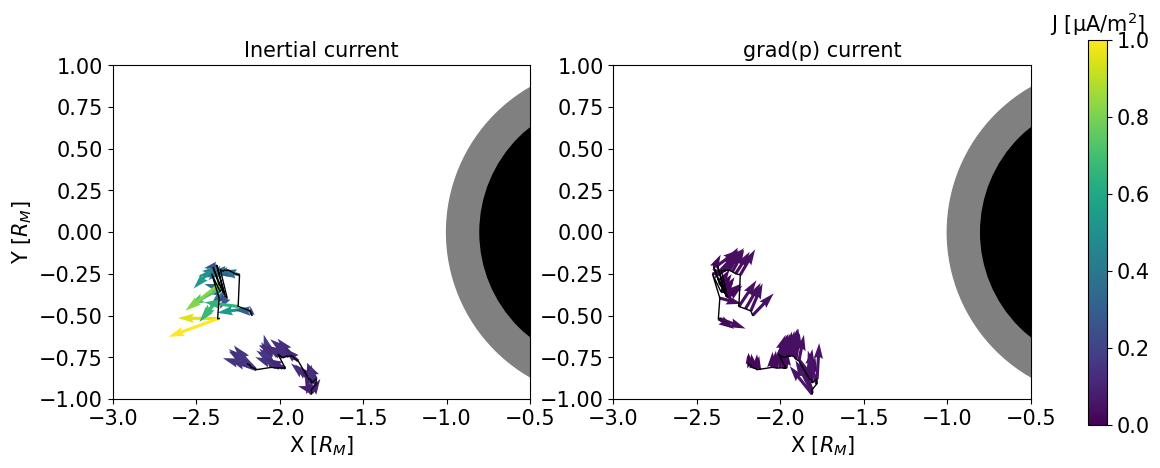

In [14]:
# PLOT TOTAL DF data

fig,ax = plt.subplots(ncols = 2, figsize=(17,5))
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        ax[0].plot(df_data[key]["X"],df_data[key]["Y"], color='black', lw = 1)
        ax[1].plot(df_data[key]["X"],df_data[key]["Y"], color='black', lw = 1)
        J_inrt = ax[0].quiver(df_data[key]["X"],df_data[key]["Y"],df_data[key]["J_inrt,x"],df_data[key]["J_inrt,y"],
                              np.sqrt(df_data[key]["J_inrt,x"]**2+df_data[key]["J_inrt,y"]**2+df_data[key]["J_inrt,z"]**2)*1e6,
                       cmap='viridis',clim=[0,1])
        J_gradp = ax[1].quiver(df_data[key]["X"],df_data[key]["Y"],df_data[key]["J_gradp,x"],df_data[key]["J_gradp,y"],
                              np.sqrt(df_data[key]["J_gradp,x"]**2+df_data[key]["J_gradp,y"]**2+df_data[key]["J_gradp,z"]**2)*1e6,
                               cmap='viridis',clim=[0,1])
        #s = 500*data[key]["area"],

for i in [0,1]:
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    ax[i].add_patch(outer)
    ax[i].add_patch(inner)
    ax[i].set_ylim(-1,1)
    ax[i].set_xlim(-3,-0.5)
    ax[i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[i].tick_params(axis='both',labelsize=15)
    ax[i].set_xlabel("X [$R_M$]",fontsize=15)
    ax[i].set_ylabel("Y [$R_M$]",fontsize=15)
ax[0].set_title("Inertial current",fontsize=15)
ax[1].set_title("grad(p) current",fontsize=15)
fig.subplots_adjust(right=0.8)
cbar1 = fig.colorbar(J_inrt, ax=ax[:])
cbar1.ax.tick_params(labelsize=15)
cbar1.ax.set_title('J [μA/m$^2$]',fontsize=15)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_currents.png'),bbox_inches='tight',dpi = 300)

Text(0, 0.5, 'Electron pressure [$nPa$]')

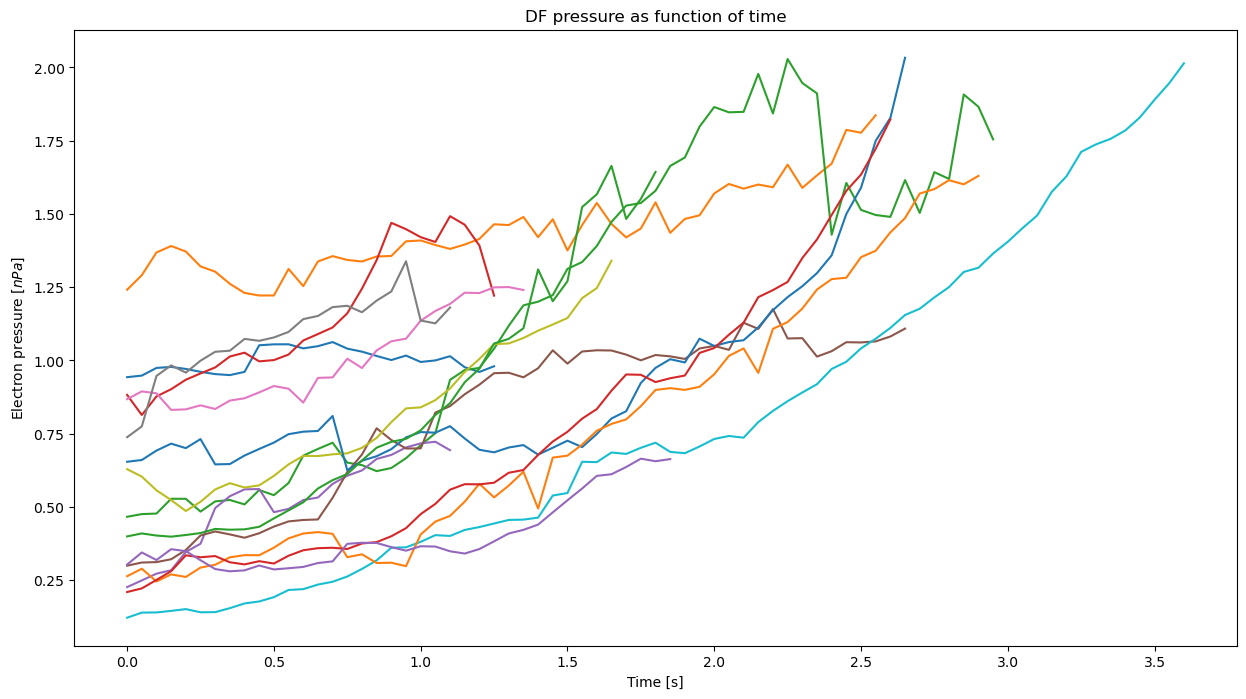

In [70]:
fig,ax = plt.subplots(figsize=(15,8))
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        plot = ax.plot(df_data[key]["time"]-df_data[key]["time"][0],df_data[key]["pe"]*1e9)
        #s = 500*data[key]["area"],
ax.set_title("DF pressure as function of time")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Electron pressure [$nPa$]")
#ax.set_xscale("log")
#ax.set_yscale("log")

Text(0, 0.5, '$pe/n^{5/3}$')

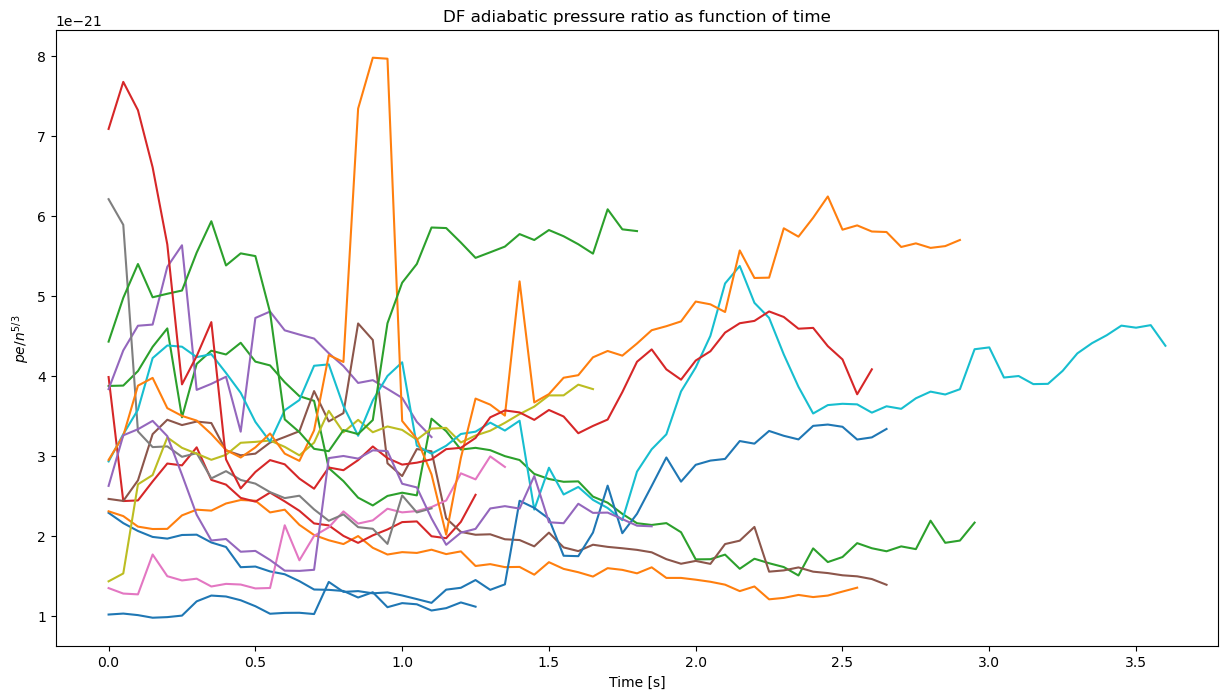

In [73]:
fig,ax = plt.subplots(figsize=(15,8))
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        plot = ax.plot(df_data[key]["time"]-df_data[key]["time"][0],df_data[key]["pe"]*1e9/(df_data[key]["n"]*1e6)**(5/3))
        #s = 500*data[key]["area"],
ax.set_title("DF adiabatic pressure ratio as function of time")
ax.set_xlabel("Time [s]")
ax.set_ylabel("$pe/n^{5/3}$")
#ax.set_xscale("log")
#ax.set_yscale("log")

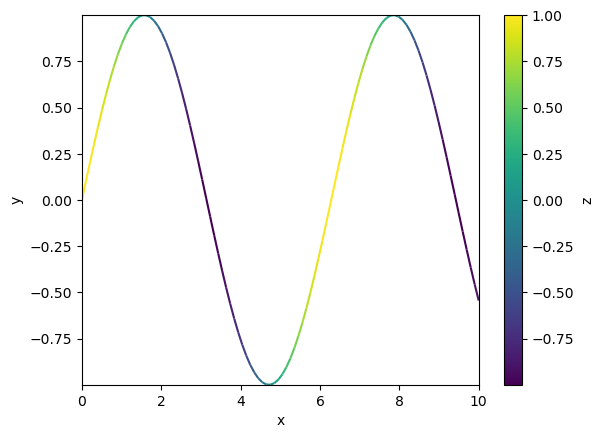

In [95]:
# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)
z = np.cos(x)  # The third variable affecting the color

# Create a set of line segments so that each segment is colored separately
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection from the segments
cmap = plt.get_cmap('viridis')  # You can choose any colormap you like
norm = plt.Normalize(z.min(), z.max())
lc = LineCollection(segments, cmap=cmap, norm=norm)

# Set the values used for colormapping
lc.set_array(z)

# Add the collection to the plot
fig, ax = plt.subplots()
ax.add_collection(lc)

# Set the limits and labels of the plot
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel('x')
ax.set_ylabel('y')

# Add a color bar to the plot
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('z')

plt.show()

In [12]:
(10-3.6)*R_M**2*1e-9*1e-6

0.03810304

In [16]:
1.13e-2*R_M*1e-6

0.027572

In [24]:
data.keys()

dict_keys(['X', 'Y', 'Z', 'Bx', 'By', 'Bz', 'Ex', 'Ey', 'Ez', 'rhoS0', 'uxS0', 'uyS0', 'uzS0', 'pxxS0', 'pyyS0', 'pzzS0', 'pxyS0', 'pxzS0', 'pyzS0', 'rhoS1', 'uxS1', 'uyS1', 'uzS1', 'pxxS1', 'pyyS1', 'pzzS1', 'pxyS1', 'pxzS1', 'pyzS1', 'Jx', 'Jy', 'Jz', 'dp_dx', 'dp_dy', 'dp_dz', 'dB_dx', 'dB_dy', 'dB_dz'])